"""
저장한 모델을 사용할 시는 6번의 모델 Load로 이동하여 제출한 파일의 경로를 설정한 후 진행
"""

1. bitstring 모듈 설치 for 데이터 로더


In [2]:
!pip install -q bitstring
#!pip install pytorchtools
#from google.colab import drive
#drive.mount('/content/drive')

#!ls '/content/drive/'
#!mkdir -p '/content/drive/My Drive/Autoencoder_1bit'
#!ls -Fcal '/content/drive/My Drive/Autoencoder_1bit' #check existence

#df = pd.DataFrame(np.random.rand(10, 5))
#df.to_csv("/content/drive/My Drive/Autoencoder_1bit/df.csv")
#!ls -Fcal '/content/drive/My Drive/Autoencoder_1bit/df.csv' #check existence

2. 모델 설정(Autoencoder 및 BNN)

In [3]:
from tqdm import tqdm

import math
from torch.autograd import Function

import torch 
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import matplotlib.pyplot as plt
# import torch.utils.data as D
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
#from modules import *
from torchvision import datasets,transforms
import argparse
import numpy as np
import torch.nn.init as init
import bitstring
from bitstring import BitArray, ConstBitStream
import pandas as pd
import tensorflow.compat.v1 as tf
from IPython.display import SVG
import pandas as pd
from sklearn import model_selection
#from pytorchtools import EarlyStopping

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
class BinarizeF(Function):

    @staticmethod
    def forward(cxt, input):
        output = input.new(input.size())
        output[input > 0] = 1
        # output[input <= 0] = -1
        output[input <= 0] = 0

        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input

# aliases
binarize = BinarizeF.apply

class BinaryTanh(nn.Module):
    def __init__(self):
        super(BinaryTanh, self).__init__()
        self.hardtanh = nn.Hardtanh()

    def forward(self, input):
        output = self.hardtanh(input)
        output = binarize(output)
        return output
        
class BinarySigmoid(nn.Module):
    def __init__(self):
        super(BinarySigmoid, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.sigmoid(input)
        output = binarize(output)
        return output

class BinaryRelu(nn.Module):
    def __init__(self):
        super(BinaryRelu, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.relu(input)
        output = binarize(output)
        return output

class BinaryLinear(nn.Linear):

    def forward(self, input):
        binary_weight = binarize(self.weight)
        if self.bias is None:
            return F.linear(input, binary_weight)
        else:
            return F.linear(input, binary_weight, self.bias)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv



class BinaryConv2d(nn.Conv2d):

    def forward(self, input):
        bw = binarize(self.weight)
        return F.conv2d(input, bw, self.bias, self.stride,
                               self.padding, self.dilation, self.groups)

    def reset_parameters(self):
        # Glorot initialization
        in_features = self.in_channels
        out_features = self.out_channels
        for k in self.kernel_size:
            in_features *= k
            out_features *= k
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv
        
def timeSince(since):
    now = time.time()
    s = now - since
    #m = math.floor(s / 60)
    #s -= m * 60
    return s
def convert_bit_str(input_bit_str):
    input_bit = []
    for i in range(len(input_bit_str)):
        input_bit.append(int(input_bit_str[i]))
    
    input_bit = np.array(input_bit) # n
    input_bit = pd.DataFrame(input_bit)
    input_bit = input_bit.values
    
    x_train = input_bit
    x_train = np.reshape(x_train, (x_train.shape[1], x_train.shape[0]))        
    return(x_train)

class DenseBlock(nn.Module):
    def __init__(self,nb_layers,in_planes,growh_rate,block,dropRate=0.0):
        super(DenseBlock,self).__init__()
        self.layer = self._make_layer(block, in_planes, growh_rate, nb_layers, dropRate)
    
    def _make_layer(self,block,in_planes,growh_rate,nb_layers,dropRate):
        layers=[]
        for i in range(nb_layers):
            layers.append(block(in_planes + i*growh_rate ,growh_rate,dropRate))
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        return self.layer(x)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

"Model: Autoencoder"

class Model(nn.Module): 
    def __init__(self):
        super(Model,self).__init__()
        #encoder
        self.layer1 = nn.Sequential(   
            nn.Linear(length,length_latent),
            BinaryTanh()        
            )
        #decoder
        length_coeff = 16
        self.layer2 = nn.Sequential(
            
            #nn.Linear(length_latent,length_latent),
            #nn.ReLU(),
            
            nn.Linear(length_latent,length_coeff*length),
            
            nn.Linear(length_coeff*length,length_coeff*length),
            nn.ReLU(),
            
            nn.Linear(length_coeff*length,length_coeff*length),
            nn.ReLU(),
            
            nn.Linear(length_coeff*length,length_coeff*length),
            nn.ReLU(),
                        
            nn.Linear(length_coeff*length,1*length)   
            )
            
    def forward(self, x):
        # x = x.view(length,-1)
        encoded = self.layer1(x)
        decoded = self.layer2(encoded)

        return encoded, decoded


cuda:0


3. hyperparameters 설정 및 데이터 로더

In [6]:

"Hyperparameter"
EPOCH = 1000
#EPOCH = 10
epochs = EPOCH
# BATCH_SIZE = 64
# BATCH_SIZE = 5
USE_CUDA = torch.cuda.is_available()
DEVICE = device
print("Using Device:", DEVICE)

batch_size = 10
length = 10
length_latent = 20
bit_num = 10
#early stopping
patiences = 100
deltas = 0.00001 
learning_rate = 0.0001



""" Load data """

input_bit_list = [] # Y
integer_list = [] # X
input_bit_str_each1 = np.zeros((1024, 10))
for i in range(0, 2**bit_num):
    integer_num = i
    input_bit_str = BitArray(uint=i, length=bit_num).bin
    input_bit_str_each = np.array(convert_bit_str(input_bit_str)).transpose()
    input_bit_str_each.resize(10,)
    input_bit_str_each1[i,:] = input_bit_str_each
    input_bit_list.append(input_bit_str)
    integer_list.append(integer_num)
    

    
bit_list = pd.DataFrame(input_bit_list)
integer_num = pd.DataFrame(integer_list)
data = pd.concat([bit_list, integer_num], axis=1)

##
# input_bit_str_each2 = np.where(input_bit_str_each1==0, -1, input_bit_str_each1)
# input_bit_str_each1 = input_bit_str_each2

x_train, x_valid = model_selection.train_test_split(input_bit_str_each1, test_size = 0.99, random_state = 0)

x_train = input_bit_str_each1
x_test = input_bit_str_each1

# noise_factor = 0.0005
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=0.001, size=x_train.shape) 
# x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=0.001, size=x_test.shape) 
# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# x_test_noisy = np.clip(x_test_noisy, 0., 1.)

train_loader = torch.tensor(x_train)
test_loader = torch.tensor(x_test)
valid_loder = torch.tensor(x_valid)
 

"""optimal struct"""

model = Model().to(device)
########################################################################

        
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



Using Device: cuda:0


4. 모델 training 및 test

1024it [00:05, 196.68it/s]
1014it [00:01, 652.72it/s]
19it [00:00, 183.53it/s]

[   1/1000] train_loss: 0.18895 valid_loss: 0.30998
Validation loss decreased (inf --> 0.309978).  Saving model ...


1024it [00:05, 195.13it/s]
1014it [00:01, 655.92it/s]
21it [00:00, 205.35it/s]

[   2/1000] train_loss: 0.13979 valid_loss: 0.27341
Validation loss decreased (0.309978 --> 0.273411).  Saving model ...


1024it [00:05, 198.81it/s]
1014it [00:01, 671.08it/s]
17it [00:00, 164.83it/s]

[   3/1000] train_loss: 0.11948 valid_loss: 0.24987
Validation loss decreased (0.273411 --> 0.249865).  Saving model ...


1024it [00:05, 199.61it/s]
1014it [00:01, 655.21it/s]
21it [00:00, 207.05it/s]

[   4/1000] train_loss: 0.10354 valid_loss: 0.23521
Validation loss decreased (0.249865 --> 0.235206).  Saving model ...


1024it [00:05, 198.87it/s]
1014it [00:01, 668.95it/s]
18it [00:00, 172.55it/s]

[   5/1000] train_loss: 0.09055 valid_loss: 0.22508
Validation loss decreased (0.235206 --> 0.225084).  Saving model ...


1024it [00:05, 198.48it/s]
1014it [00:01, 648.63it/s]
20it [00:00, 196.99it/s]

[   6/1000] train_loss: 0.08582 valid_loss: 0.22499
Validation loss decreased (0.225084 --> 0.224992).  Saving model ...


1024it [00:05, 200.21it/s]
1014it [00:01, 661.31it/s]
20it [00:00, 192.52it/s]

[   7/1000] train_loss: 0.08193 valid_loss: 0.21586
Validation loss decreased (0.224992 --> 0.215863).  Saving model ...


1024it [00:05, 196.61it/s]
1014it [00:01, 650.96it/s]
20it [00:00, 197.73it/s]

[   8/1000] train_loss: 0.07778 valid_loss: 0.21230
Validation loss decreased (0.215863 --> 0.212303).  Saving model ...


1024it [00:05, 198.02it/s]
1014it [00:01, 667.01it/s]
20it [00:00, 198.91it/s]

[   9/1000] train_loss: 0.07466 valid_loss: 0.20566
Validation loss decreased (0.212303 --> 0.205662).  Saving model ...


1024it [00:05, 196.31it/s]
1014it [00:01, 673.12it/s]
17it [00:00, 165.82it/s]

[  10/1000] train_loss: 0.07099 valid_loss: 0.19930
Validation loss decreased (0.205662 --> 0.199297).  Saving model ...


1024it [00:05, 195.40it/s]
1014it [00:01, 658.63it/s]
20it [00:00, 198.40it/s]

[  11/1000] train_loss: 0.06749 valid_loss: 0.18980
Validation loss decreased (0.199297 --> 0.189799).  Saving model ...


1024it [00:05, 200.35it/s]
1014it [00:01, 675.28it/s]
20it [00:00, 193.26it/s]

[  12/1000] train_loss: 0.06441 valid_loss: 0.18122
Validation loss decreased (0.189799 --> 0.181222).  Saving model ...


1024it [00:05, 196.35it/s]
1014it [00:01, 684.92it/s]
17it [00:00, 169.37it/s]

[  13/1000] train_loss: 0.06143 valid_loss: 0.17956
Validation loss decreased (0.181222 --> 0.179557).  Saving model ...


1024it [00:05, 199.79it/s]
1014it [00:01, 684.43it/s]
21it [00:00, 209.28it/s]

[  14/1000] train_loss: 0.05843 valid_loss: 0.17403
Validation loss decreased (0.179557 --> 0.174034).  Saving model ...


1024it [00:05, 197.99it/s]
1014it [00:01, 670.82it/s]
20it [00:00, 196.48it/s]

[  15/1000] train_loss: 0.05510 valid_loss: 0.16574
Validation loss decreased (0.174034 --> 0.165737).  Saving model ...


1024it [00:05, 195.08it/s]
1014it [00:01, 678.07it/s]
21it [00:00, 204.85it/s]

[  16/1000] train_loss: 0.05258 valid_loss: 0.15298
Validation loss decreased (0.165737 --> 0.152984).  Saving model ...


1024it [00:05, 190.29it/s]
1014it [00:01, 659.26it/s]
20it [00:00, 199.37it/s]

[  17/1000] train_loss: 0.05003 valid_loss: 0.14736
Validation loss decreased (0.152984 --> 0.147365).  Saving model ...


1024it [00:05, 197.67it/s]
1014it [00:01, 664.38it/s]
19it [00:00, 185.66it/s]

[  18/1000] train_loss: 0.04729 valid_loss: 0.14315
Validation loss decreased (0.147365 --> 0.143154).  Saving model ...


1024it [00:05, 197.85it/s]
1014it [00:01, 662.97it/s]
21it [00:00, 203.54it/s]

[  19/1000] train_loss: 0.04444 valid_loss: 0.14210
Validation loss decreased (0.143154 --> 0.142100).  Saving model ...


1024it [00:05, 197.49it/s]
1014it [00:01, 655.63it/s]
21it [00:00, 206.40it/s]

[  20/1000] train_loss: 0.04231 valid_loss: 0.13867
Validation loss decreased (0.142100 --> 0.138670).  Saving model ...


1024it [00:05, 196.92it/s]
1014it [00:01, 675.65it/s]
18it [00:00, 175.79it/s]

[  21/1000] train_loss: 0.03979 valid_loss: 0.13989
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.01it/s]
1014it [00:01, 657.36it/s]
21it [00:00, 206.55it/s]

[  22/1000] train_loss: 0.03848 valid_loss: 0.13476
Validation loss decreased (0.138670 --> 0.134756).  Saving model ...


1024it [00:05, 195.37it/s]
1014it [00:01, 670.88it/s]
19it [00:00, 185.87it/s]

[  23/1000] train_loss: 0.03676 valid_loss: 0.12851
Validation loss decreased (0.134756 --> 0.128508).  Saving model ...


1024it [00:05, 196.08it/s]
1014it [00:01, 677.85it/s]
19it [00:00, 182.20it/s]

[  24/1000] train_loss: 0.03459 valid_loss: 0.12181
Validation loss decreased (0.128508 --> 0.121806).  Saving model ...


1024it [00:05, 194.99it/s]
1014it [00:01, 646.23it/s]
20it [00:00, 194.31it/s]

[  25/1000] train_loss: 0.03297 valid_loss: 0.11895
Validation loss decreased (0.121806 --> 0.118950).  Saving model ...


1024it [00:05, 196.75it/s]
1014it [00:01, 677.39it/s]
22it [00:00, 214.28it/s]

[  26/1000] train_loss: 0.03194 valid_loss: 0.11419
Validation loss decreased (0.118950 --> 0.114191).  Saving model ...


1024it [00:04, 205.66it/s]
1014it [00:01, 677.63it/s]
21it [00:00, 205.58it/s]

[  27/1000] train_loss: 0.03107 valid_loss: 0.11125
Validation loss decreased (0.114191 --> 0.111255).  Saving model ...


1024it [00:05, 203.64it/s]
1014it [00:01, 678.98it/s]
20it [00:00, 199.39it/s]

[  28/1000] train_loss: 0.03006 valid_loss: 0.11008
Validation loss decreased (0.111255 --> 0.110081).  Saving model ...


1024it [00:05, 201.52it/s]
1014it [00:01, 683.38it/s]
22it [00:00, 211.08it/s]

[  29/1000] train_loss: 0.02934 valid_loss: 0.11007
EarlyStopping counter: 1 out of 100


1024it [00:04, 206.20it/s]
1014it [00:01, 704.42it/s]
22it [00:00, 215.28it/s]

[  30/1000] train_loss: 0.02822 valid_loss: 0.10522
Validation loss decreased (0.110081 --> 0.105222).  Saving model ...


1024it [00:05, 204.51it/s]
1014it [00:01, 672.13it/s]
22it [00:00, 213.45it/s]

[  31/1000] train_loss: 0.02728 valid_loss: 0.10640
EarlyStopping counter: 1 out of 100


1024it [00:05, 202.69it/s]
1014it [00:01, 679.70it/s]
21it [00:00, 208.20it/s]

[  32/1000] train_loss: 0.02630 valid_loss: 0.10039
Validation loss decreased (0.105222 --> 0.100386).  Saving model ...


1024it [00:05, 204.54it/s]
1014it [00:01, 699.14it/s]
20it [00:00, 197.55it/s]

[  33/1000] train_loss: 0.02529 valid_loss: 0.10064
EarlyStopping counter: 1 out of 100


1024it [00:05, 204.08it/s]
1014it [00:01, 690.91it/s]
21it [00:00, 209.25it/s]

[  34/1000] train_loss: 0.02469 valid_loss: 0.10001
Validation loss decreased (0.100386 --> 0.100008).  Saving model ...


1024it [00:05, 202.67it/s]
1014it [00:01, 696.28it/s]
21it [00:00, 202.82it/s]

[  35/1000] train_loss: 0.02398 valid_loss: 0.09922
Validation loss decreased (0.100008 --> 0.099222).  Saving model ...


1024it [00:05, 204.00it/s]
1014it [00:01, 693.31it/s]
20it [00:00, 194.72it/s]

[  36/1000] train_loss: 0.02362 valid_loss: 0.09910
Validation loss decreased (0.099222 --> 0.099101).  Saving model ...


1024it [00:04, 205.10it/s]
1014it [00:01, 702.27it/s]
18it [00:00, 178.83it/s]

[  37/1000] train_loss: 0.02310 valid_loss: 0.10277
EarlyStopping counter: 1 out of 100


1024it [00:04, 205.82it/s]
1014it [00:01, 672.37it/s]
20it [00:00, 198.19it/s]

[  38/1000] train_loss: 0.02246 valid_loss: 0.10208
EarlyStopping counter: 2 out of 100


1024it [00:05, 202.20it/s]
1014it [00:01, 674.85it/s]
20it [00:00, 198.95it/s]

[  39/1000] train_loss: 0.02180 valid_loss: 0.10109
EarlyStopping counter: 3 out of 100


1024it [00:04, 204.83it/s]
1014it [00:01, 683.61it/s]
22it [00:00, 211.63it/s]

[  40/1000] train_loss: 0.02130 valid_loss: 0.10031
EarlyStopping counter: 4 out of 100


1024it [00:05, 202.50it/s]
1014it [00:01, 675.90it/s]
19it [00:00, 186.01it/s]

[  41/1000] train_loss: 0.02057 valid_loss: 0.10169
EarlyStopping counter: 5 out of 100


1024it [00:05, 198.22it/s]
1014it [00:01, 685.69it/s]
21it [00:00, 200.18it/s]

[  42/1000] train_loss: 0.02046 valid_loss: 0.09950
EarlyStopping counter: 6 out of 100


1024it [00:05, 200.54it/s]
1014it [00:01, 649.63it/s]
18it [00:00, 172.92it/s]

[  43/1000] train_loss: 0.02011 valid_loss: 0.09994
EarlyStopping counter: 7 out of 100


1024it [00:05, 194.21it/s]
1014it [00:01, 649.86it/s]
21it [00:00, 202.06it/s]

[  44/1000] train_loss: 0.01968 valid_loss: 0.10128
EarlyStopping counter: 8 out of 100


1024it [00:05, 195.98it/s]
1014it [00:01, 655.37it/s]
21it [00:00, 205.07it/s]

[  45/1000] train_loss: 0.01920 valid_loss: 0.10201
EarlyStopping counter: 9 out of 100


1024it [00:05, 198.73it/s]
1014it [00:01, 657.77it/s]
21it [00:00, 209.21it/s]

[  46/1000] train_loss: 0.01882 valid_loss: 0.09949
EarlyStopping counter: 10 out of 100


1024it [00:05, 196.22it/s]
1014it [00:01, 673.42it/s]
21it [00:00, 209.50it/s]

[  47/1000] train_loss: 0.01836 valid_loss: 0.09984
EarlyStopping counter: 11 out of 100


1024it [00:05, 198.56it/s]
1014it [00:01, 668.39it/s]
18it [00:00, 175.79it/s]

[  48/1000] train_loss: 0.01826 valid_loss: 0.10229
EarlyStopping counter: 12 out of 100


1024it [00:05, 196.81it/s]
1014it [00:01, 664.64it/s]
20it [00:00, 195.34it/s]

[  49/1000] train_loss: 0.01763 valid_loss: 0.10068
EarlyStopping counter: 13 out of 100


1024it [00:05, 195.63it/s]
1014it [00:01, 655.75it/s]
18it [00:00, 172.55it/s]

[  50/1000] train_loss: 0.01715 valid_loss: 0.10077
EarlyStopping counter: 14 out of 100


1024it [00:05, 196.44it/s]
1014it [00:01, 669.98it/s]
21it [00:00, 207.33it/s]

[  51/1000] train_loss: 0.01699 valid_loss: 0.09621
Validation loss decreased (0.099101 --> 0.096209).  Saving model ...


1024it [00:05, 198.20it/s]
1014it [00:01, 669.23it/s]
22it [00:00, 212.30it/s]

[  52/1000] train_loss: 0.01673 valid_loss: 0.09745
EarlyStopping counter: 1 out of 100


1024it [00:05, 199.11it/s]
1014it [00:01, 655.90it/s]
19it [00:00, 188.48it/s]

[  53/1000] train_loss: 0.01646 valid_loss: 0.09536
Validation loss decreased (0.096209 --> 0.095356).  Saving model ...


1024it [00:05, 194.86it/s]
1014it [00:01, 677.12it/s]
19it [00:00, 181.67it/s]

[  54/1000] train_loss: 0.01657 valid_loss: 0.09516
Validation loss decreased (0.095356 --> 0.095165).  Saving model ...


1024it [00:05, 197.22it/s]
1014it [00:01, 651.88it/s]
21it [00:00, 208.98it/s]

[  55/1000] train_loss: 0.01599 valid_loss: 0.09624
EarlyStopping counter: 1 out of 100


1024it [00:05, 202.20it/s]
1014it [00:01, 648.24it/s]
21it [00:00, 206.31it/s]

[  56/1000] train_loss: 0.01557 valid_loss: 0.09336
Validation loss decreased (0.095165 --> 0.093361).  Saving model ...


1024it [00:05, 200.81it/s]
1014it [00:01, 682.90it/s]
21it [00:00, 208.27it/s]

[  57/1000] train_loss: 0.01511 valid_loss: 0.09292
Validation loss decreased (0.093361 --> 0.092918).  Saving model ...


1024it [00:05, 201.07it/s]
1014it [00:01, 683.08it/s]
22it [00:00, 213.83it/s]

[  58/1000] train_loss: 0.01502 valid_loss: 0.09330
EarlyStopping counter: 1 out of 100


1024it [00:05, 202.13it/s]
1014it [00:01, 654.93it/s]
21it [00:00, 208.35it/s]

[  59/1000] train_loss: 0.01469 valid_loss: 0.09073
Validation loss decreased (0.092918 --> 0.090726).  Saving model ...


1024it [00:05, 199.54it/s]
1014it [00:01, 688.30it/s]
20it [00:00, 194.77it/s]

[  60/1000] train_loss: 0.01412 valid_loss: 0.08748
Validation loss decreased (0.090726 --> 0.087482).  Saving model ...


1024it [00:05, 200.16it/s]
1014it [00:01, 652.68it/s]
20it [00:00, 199.62it/s]

[  61/1000] train_loss: 0.01371 valid_loss: 0.08563
Validation loss decreased (0.087482 --> 0.085632).  Saving model ...


1024it [00:05, 202.25it/s]
1014it [00:01, 681.95it/s]
18it [00:00, 175.94it/s]

[  62/1000] train_loss: 0.01326 valid_loss: 0.08847
EarlyStopping counter: 1 out of 100


1024it [00:05, 191.82it/s]
1014it [00:01, 662.46it/s]
20it [00:00, 195.24it/s]

[  63/1000] train_loss: 0.01323 valid_loss: 0.09036
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.02it/s]
1014it [00:01, 657.26it/s]
21it [00:00, 204.53it/s]

[  64/1000] train_loss: 0.01284 valid_loss: 0.08684
EarlyStopping counter: 3 out of 100


1024it [00:05, 196.03it/s]
1014it [00:01, 671.90it/s]
19it [00:00, 183.52it/s]

[  65/1000] train_loss: 0.01261 valid_loss: 0.08687
EarlyStopping counter: 4 out of 100


1024it [00:06, 157.63it/s]
1014it [00:01, 658.37it/s]
20it [00:00, 194.78it/s]

[  66/1000] train_loss: 0.01235 valid_loss: 0.08561
Validation loss decreased (0.085632 --> 0.085611).  Saving model ...


1024it [00:05, 195.53it/s]
1014it [00:01, 641.50it/s]
20it [00:00, 197.54it/s]

[  67/1000] train_loss: 0.01196 valid_loss: 0.08343
Validation loss decreased (0.085611 --> 0.083429).  Saving model ...


1024it [00:05, 196.93it/s]
1014it [00:01, 690.24it/s]
20it [00:00, 191.38it/s]

[  68/1000] train_loss: 0.01169 valid_loss: 0.08221
Validation loss decreased (0.083429 --> 0.082214).  Saving model ...


1024it [00:05, 200.16it/s]
1014it [00:01, 659.26it/s]
19it [00:00, 188.60it/s]

[  69/1000] train_loss: 0.01180 valid_loss: 0.08045
Validation loss decreased (0.082214 --> 0.080454).  Saving model ...


1024it [00:05, 200.98it/s]
1014it [00:01, 657.38it/s]
22it [00:00, 214.50it/s]

[  70/1000] train_loss: 0.01160 valid_loss: 0.08000
Validation loss decreased (0.080454 --> 0.079999).  Saving model ...


1024it [00:05, 194.53it/s]
1014it [00:01, 666.36it/s]
18it [00:00, 179.77it/s]

[  71/1000] train_loss: 0.01158 valid_loss: 0.07876
Validation loss decreased (0.079999 --> 0.078762).  Saving model ...


1024it [00:05, 193.98it/s]
1014it [00:01, 679.16it/s]
19it [00:00, 182.77it/s]

[  72/1000] train_loss: 0.01112 valid_loss: 0.07590
Validation loss decreased (0.078762 --> 0.075896).  Saving model ...


1024it [00:05, 195.12it/s]
1014it [00:01, 669.58it/s]
20it [00:00, 197.16it/s]

[  73/1000] train_loss: 0.01096 valid_loss: 0.07664
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.36it/s]
1014it [00:01, 686.77it/s]
20it [00:00, 199.28it/s]

[  74/1000] train_loss: 0.01082 valid_loss: 0.07666
EarlyStopping counter: 2 out of 100


1024it [00:05, 197.09it/s]
1014it [00:01, 652.63it/s]
21it [00:00, 204.57it/s]

[  75/1000] train_loss: 0.01102 valid_loss: 0.07572
Validation loss decreased (0.075896 --> 0.075717).  Saving model ...


1024it [00:05, 192.70it/s]
1014it [00:01, 646.49it/s]
21it [00:00, 204.15it/s]

[  76/1000] train_loss: 0.01065 valid_loss: 0.07607
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.92it/s]
1014it [00:01, 676.15it/s]
15it [00:00, 148.87it/s]

[  77/1000] train_loss: 0.01067 valid_loss: 0.07451
Validation loss decreased (0.075717 --> 0.074511).  Saving model ...


1024it [00:05, 194.65it/s]
1014it [00:01, 662.91it/s]
17it [00:00, 167.53it/s]

[  78/1000] train_loss: 0.01009 valid_loss: 0.07297
Validation loss decreased (0.074511 --> 0.072973).  Saving model ...


1024it [00:05, 198.34it/s]
1014it [00:01, 685.18it/s]
21it [00:00, 205.32it/s]

[  79/1000] train_loss: 0.01000 valid_loss: 0.07213
Validation loss decreased (0.072973 --> 0.072126).  Saving model ...


1024it [00:05, 199.24it/s]
1014it [00:01, 657.68it/s]
22it [00:00, 212.03it/s]

[  80/1000] train_loss: 0.00979 valid_loss: 0.07214
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.90it/s]
1014it [00:01, 688.57it/s]
22it [00:00, 212.61it/s]

[  81/1000] train_loss: 0.00955 valid_loss: 0.07267
EarlyStopping counter: 2 out of 100


1024it [00:05, 198.45it/s]
1014it [00:01, 647.14it/s]
19it [00:00, 184.81it/s]

[  82/1000] train_loss: 0.00913 valid_loss: 0.07168
Validation loss decreased (0.072126 --> 0.071679).  Saving model ...


1024it [00:05, 197.10it/s]
1014it [00:01, 657.53it/s]
20it [00:00, 197.39it/s]

[  83/1000] train_loss: 0.00911 valid_loss: 0.07008
Validation loss decreased (0.071679 --> 0.070077).  Saving model ...


1024it [00:05, 197.20it/s]
1014it [00:01, 670.01it/s]
21it [00:00, 199.36it/s]

[  84/1000] train_loss: 0.00910 valid_loss: 0.07228
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.29it/s]
1014it [00:01, 645.61it/s]
20it [00:00, 198.06it/s]

[  85/1000] train_loss: 0.00938 valid_loss: 0.07240
EarlyStopping counter: 2 out of 100


1024it [00:05, 197.79it/s]
1014it [00:01, 682.06it/s]
20it [00:00, 195.63it/s]

[  86/1000] train_loss: 0.00887 valid_loss: 0.07179
EarlyStopping counter: 3 out of 100


1024it [00:05, 197.41it/s]
1014it [00:01, 664.32it/s]
19it [00:00, 186.62it/s]

[  87/1000] train_loss: 0.00864 valid_loss: 0.07062
EarlyStopping counter: 4 out of 100


1024it [00:05, 199.56it/s]
1014it [00:01, 688.26it/s]
20it [00:00, 194.29it/s]

[  88/1000] train_loss: 0.00836 valid_loss: 0.07015
EarlyStopping counter: 5 out of 100


1024it [00:05, 196.69it/s]
1014it [00:01, 655.20it/s]
17it [00:00, 164.75it/s]

[  89/1000] train_loss: 0.00833 valid_loss: 0.07194
EarlyStopping counter: 6 out of 100


1024it [00:05, 195.03it/s]
1014it [00:01, 689.80it/s]
20it [00:00, 190.90it/s]

[  90/1000] train_loss: 0.00800 valid_loss: 0.07117
EarlyStopping counter: 7 out of 100


1024it [00:05, 202.13it/s]
1014it [00:01, 669.34it/s]
20it [00:00, 195.38it/s]

[  91/1000] train_loss: 0.00811 valid_loss: 0.06901
Validation loss decreased (0.070077 --> 0.069007).  Saving model ...


1024it [00:05, 197.20it/s]
1014it [00:01, 656.78it/s]
18it [00:00, 175.34it/s]

[  92/1000] train_loss: 0.00811 valid_loss: 0.07106
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.50it/s]
1014it [00:01, 662.01it/s]
21it [00:00, 204.03it/s]

[  93/1000] train_loss: 0.00776 valid_loss: 0.06836
Validation loss decreased (0.069007 --> 0.068358).  Saving model ...


1024it [00:05, 197.88it/s]
1014it [00:01, 649.64it/s]
20it [00:00, 198.29it/s]

[  94/1000] train_loss: 0.00740 valid_loss: 0.06825
Validation loss decreased (0.068358 --> 0.068252).  Saving model ...


1024it [00:05, 195.11it/s]
1014it [00:01, 660.87it/s]
19it [00:00, 184.66it/s]

[  95/1000] train_loss: 0.00733 valid_loss: 0.06681
Validation loss decreased (0.068252 --> 0.066814).  Saving model ...


1024it [00:05, 194.54it/s]
1014it [00:01, 645.65it/s]
20it [00:00, 192.09it/s]

[  96/1000] train_loss: 0.00756 valid_loss: 0.06844
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.01it/s]
1014it [00:01, 658.49it/s]
20it [00:00, 195.38it/s]

[  97/1000] train_loss: 0.00767 valid_loss: 0.06719
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.84it/s]
1014it [00:01, 649.80it/s]
21it [00:00, 206.97it/s]

[  98/1000] train_loss: 0.00750 valid_loss: 0.06413
Validation loss decreased (0.066814 --> 0.064126).  Saving model ...


1024it [00:05, 196.54it/s]
1014it [00:01, 656.13it/s]
21it [00:00, 202.86it/s]

[  99/1000] train_loss: 0.00718 valid_loss: 0.06700
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.57it/s]
1014it [00:01, 677.07it/s]
23it [00:00, 221.11it/s]

[ 100/1000] train_loss: 0.00744 valid_loss: 0.06355
Validation loss decreased (0.064126 --> 0.063549).  Saving model ...


1024it [00:04, 206.34it/s]
1014it [00:01, 665.89it/s]
19it [00:00, 186.47it/s]

[ 101/1000] train_loss: 0.00726 valid_loss: 0.06732
EarlyStopping counter: 1 out of 100


1024it [00:05, 199.82it/s]
1014it [00:01, 651.61it/s]
22it [00:00, 210.81it/s]

[ 102/1000] train_loss: 0.00695 valid_loss: 0.06630
EarlyStopping counter: 2 out of 100


1024it [00:05, 198.61it/s]
1014it [00:01, 667.05it/s]
18it [00:00, 178.32it/s]

[ 103/1000] train_loss: 0.00708 valid_loss: 0.06781
EarlyStopping counter: 3 out of 100


1024it [00:05, 195.12it/s]
1014it [00:01, 657.44it/s]
21it [00:00, 209.01it/s]

[ 104/1000] train_loss: 0.00686 valid_loss: 0.06882
EarlyStopping counter: 4 out of 100


1024it [00:05, 195.52it/s]
1014it [00:01, 635.10it/s]
20it [00:00, 193.65it/s]

[ 105/1000] train_loss: 0.00656 valid_loss: 0.06667
EarlyStopping counter: 5 out of 100


1024it [00:05, 196.46it/s]
1014it [00:01, 659.35it/s]
19it [00:00, 184.34it/s]

[ 106/1000] train_loss: 0.00687 valid_loss: 0.06822
EarlyStopping counter: 6 out of 100


1024it [00:05, 193.69it/s]
1014it [00:01, 647.31it/s]
21it [00:00, 202.48it/s]

[ 107/1000] train_loss: 0.00655 valid_loss: 0.06474
EarlyStopping counter: 7 out of 100


1024it [00:05, 191.37it/s]
1014it [00:01, 648.75it/s]
19it [00:00, 184.95it/s]

[ 108/1000] train_loss: 0.00670 valid_loss: 0.06633
EarlyStopping counter: 8 out of 100


1024it [00:05, 191.56it/s]
1014it [00:01, 641.75it/s]
19it [00:00, 183.00it/s]

[ 109/1000] train_loss: 0.00662 valid_loss: 0.06352
Validation loss decreased (0.063549 --> 0.063517).  Saving model ...


1024it [00:05, 185.72it/s]
1014it [00:01, 658.37it/s]
18it [00:00, 179.44it/s]

[ 110/1000] train_loss: 0.00695 valid_loss: 0.06651
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.99it/s]
1014it [00:01, 646.96it/s]
19it [00:00, 187.30it/s]

[ 111/1000] train_loss: 0.00701 valid_loss: 0.06392
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.68it/s]
1014it [00:01, 650.34it/s]
20it [00:00, 199.37it/s]

[ 112/1000] train_loss: 0.00678 valid_loss: 0.06326
Validation loss decreased (0.063517 --> 0.063261).  Saving model ...


1024it [00:05, 194.35it/s]
1014it [00:01, 652.07it/s]
21it [00:00, 205.53it/s]

[ 113/1000] train_loss: 0.00637 valid_loss: 0.06432
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.41it/s]
1014it [00:01, 653.28it/s]
20it [00:00, 198.35it/s]

[ 114/1000] train_loss: 0.00655 valid_loss: 0.06650
EarlyStopping counter: 2 out of 100


1024it [00:05, 195.47it/s]
1014it [00:01, 658.09it/s]
20it [00:00, 198.14it/s]

[ 115/1000] train_loss: 0.00629 valid_loss: 0.06766
EarlyStopping counter: 3 out of 100


1024it [00:05, 195.78it/s]
1014it [00:01, 666.23it/s]
21it [00:00, 202.51it/s]

[ 116/1000] train_loss: 0.00616 valid_loss: 0.06686
EarlyStopping counter: 4 out of 100


1024it [00:05, 197.02it/s]
1014it [00:01, 651.68it/s]
20it [00:00, 191.27it/s]

[ 117/1000] train_loss: 0.00618 valid_loss: 0.06472
EarlyStopping counter: 5 out of 100


1024it [00:05, 194.81it/s]
1014it [00:01, 644.36it/s]
21it [00:00, 202.03it/s]

[ 118/1000] train_loss: 0.00572 valid_loss: 0.06347
EarlyStopping counter: 6 out of 100


1024it [00:05, 197.22it/s]
1014it [00:01, 659.48it/s]
20it [00:00, 197.27it/s]

[ 119/1000] train_loss: 0.00613 valid_loss: 0.06649
EarlyStopping counter: 7 out of 100


1024it [00:05, 195.73it/s]
1014it [00:01, 669.78it/s]
16it [00:00, 154.63it/s]

[ 120/1000] train_loss: 0.00559 valid_loss: 0.06443
EarlyStopping counter: 8 out of 100


1024it [00:05, 194.58it/s]
1014it [00:01, 642.61it/s]
20it [00:00, 197.11it/s]

[ 121/1000] train_loss: 0.00555 valid_loss: 0.06124
Validation loss decreased (0.063261 --> 0.061240).  Saving model ...


1024it [00:05, 196.28it/s]
1014it [00:01, 651.01it/s]
19it [00:00, 189.53it/s]

[ 122/1000] train_loss: 0.00579 valid_loss: 0.05851
Validation loss decreased (0.061240 --> 0.058510).  Saving model ...


1024it [00:05, 192.75it/s]
1014it [00:01, 657.47it/s]
18it [00:00, 173.37it/s]

[ 123/1000] train_loss: 0.00593 valid_loss: 0.05915
EarlyStopping counter: 1 out of 100


1024it [00:05, 197.21it/s]
1014it [00:01, 669.73it/s]
19it [00:00, 184.54it/s]

[ 124/1000] train_loss: 0.00557 valid_loss: 0.05590
Validation loss decreased (0.058510 --> 0.055902).  Saving model ...


1024it [00:05, 197.19it/s]
1014it [00:01, 663.12it/s]
20it [00:00, 198.09it/s]

[ 125/1000] train_loss: 0.00588 valid_loss: 0.05412
Validation loss decreased (0.055902 --> 0.054121).  Saving model ...


1024it [00:05, 197.24it/s]
1014it [00:01, 659.81it/s]
21it [00:00, 203.50it/s]

[ 126/1000] train_loss: 0.00525 valid_loss: 0.05431
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.00it/s]
1014it [00:01, 657.28it/s]
21it [00:00, 206.24it/s]

[ 127/1000] train_loss: 0.00528 valid_loss: 0.05440
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.74it/s]
1014it [00:01, 657.74it/s]
20it [00:00, 197.55it/s]

[ 128/1000] train_loss: 0.00491 valid_loss: 0.05714
EarlyStopping counter: 3 out of 100


1024it [00:05, 195.58it/s]
1014it [00:01, 672.06it/s]
21it [00:00, 201.90it/s]

[ 129/1000] train_loss: 0.00525 valid_loss: 0.05338
Validation loss decreased (0.054121 --> 0.053379).  Saving model ...


1024it [00:05, 194.76it/s]
1014it [00:01, 653.18it/s]
19it [00:00, 185.65it/s]

[ 130/1000] train_loss: 0.00485 valid_loss: 0.05556
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.12it/s]
1014it [00:01, 655.76it/s]
18it [00:00, 174.93it/s]

[ 131/1000] train_loss: 0.00483 valid_loss: 0.05749
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.35it/s]
1014it [00:01, 634.91it/s]
20it [00:00, 197.94it/s]

[ 132/1000] train_loss: 0.00512 valid_loss: 0.05557
EarlyStopping counter: 3 out of 100


1024it [00:05, 193.72it/s]
1014it [00:01, 654.98it/s]
15it [00:00, 148.34it/s]

[ 133/1000] train_loss: 0.00491 valid_loss: 0.05601
EarlyStopping counter: 4 out of 100


1024it [00:05, 189.95it/s]
1014it [00:01, 650.06it/s]
21it [00:00, 203.61it/s]

[ 134/1000] train_loss: 0.00466 valid_loss: 0.05613
EarlyStopping counter: 5 out of 100


1024it [00:05, 193.21it/s]
1014it [00:01, 650.13it/s]
18it [00:00, 174.66it/s]

[ 135/1000] train_loss: 0.00464 valid_loss: 0.05435
EarlyStopping counter: 6 out of 100


1024it [00:05, 197.13it/s]
1014it [00:01, 656.67it/s]
18it [00:00, 179.92it/s]

[ 136/1000] train_loss: 0.00466 valid_loss: 0.05682
EarlyStopping counter: 7 out of 100


1024it [00:05, 192.48it/s]
1014it [00:01, 660.21it/s]
17it [00:00, 166.30it/s]

[ 137/1000] train_loss: 0.00436 valid_loss: 0.05331
Validation loss decreased (0.053379 --> 0.053309).  Saving model ...


1024it [00:05, 194.66it/s]
1014it [00:01, 651.56it/s]
21it [00:00, 207.85it/s]

[ 138/1000] train_loss: 0.00435 valid_loss: 0.05499
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.48it/s]
1014it [00:01, 662.92it/s]
20it [00:00, 196.76it/s]

[ 139/1000] train_loss: 0.00438 valid_loss: 0.05817
EarlyStopping counter: 2 out of 100


1024it [00:05, 192.32it/s]
1014it [00:01, 640.00it/s]
20it [00:00, 190.81it/s]

[ 140/1000] train_loss: 0.00453 valid_loss: 0.05520
EarlyStopping counter: 3 out of 100


1024it [00:05, 197.21it/s]
1014it [00:01, 635.49it/s]
18it [00:00, 177.37it/s]

[ 141/1000] train_loss: 0.00477 valid_loss: 0.05353
EarlyStopping counter: 4 out of 100


1024it [00:05, 194.48it/s]
1014it [00:01, 656.27it/s]
19it [00:00, 177.50it/s]

[ 142/1000] train_loss: 0.00485 valid_loss: 0.05710
EarlyStopping counter: 5 out of 100


1024it [00:05, 194.11it/s]
1014it [00:01, 654.52it/s]
20it [00:00, 199.87it/s]

[ 143/1000] train_loss: 0.00423 valid_loss: 0.05602
EarlyStopping counter: 6 out of 100


1024it [00:05, 193.12it/s]
1014it [00:01, 634.85it/s]
20it [00:00, 197.77it/s]

[ 144/1000] train_loss: 0.00465 valid_loss: 0.05396
EarlyStopping counter: 7 out of 100


1024it [00:05, 192.21it/s]
1014it [00:01, 653.50it/s]
19it [00:00, 189.45it/s]

[ 145/1000] train_loss: 0.00442 valid_loss: 0.05382
EarlyStopping counter: 8 out of 100


1024it [00:05, 194.33it/s]
1014it [00:01, 652.13it/s]
20it [00:00, 195.73it/s]

[ 146/1000] train_loss: 0.00413 valid_loss: 0.05183
Validation loss decreased (0.053309 --> 0.051828).  Saving model ...


1024it [00:05, 196.11it/s]
1014it [00:01, 660.49it/s]
20it [00:00, 191.74it/s]

[ 147/1000] train_loss: 0.00420 valid_loss: 0.05018
Validation loss decreased (0.051828 --> 0.050181).  Saving model ...


1024it [00:05, 194.70it/s]
1014it [00:01, 666.28it/s]
20it [00:00, 197.64it/s]

[ 148/1000] train_loss: 0.00456 valid_loss: 0.05017
EarlyStopping counter: 1 out of 100


1024it [00:05, 191.75it/s]
1014it [00:01, 647.84it/s]
19it [00:00, 184.39it/s]

[ 149/1000] train_loss: 0.00480 valid_loss: 0.04721
Validation loss decreased (0.050181 --> 0.047214).  Saving model ...


1024it [00:05, 193.60it/s]
1014it [00:01, 634.09it/s]
21it [00:00, 204.66it/s]

[ 150/1000] train_loss: 0.00431 valid_loss: 0.04802
EarlyStopping counter: 1 out of 100


1024it [00:05, 195.35it/s]
1014it [00:01, 658.88it/s]
21it [00:00, 206.42it/s]

[ 151/1000] train_loss: 0.00357 valid_loss: 0.04743
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.94it/s]
1014it [00:01, 646.33it/s]
20it [00:00, 197.87it/s]

[ 152/1000] train_loss: 0.00368 valid_loss: 0.04582
Validation loss decreased (0.047214 --> 0.045816).  Saving model ...


1024it [00:05, 188.18it/s]
1014it [00:01, 665.50it/s]
19it [00:00, 186.76it/s]

[ 153/1000] train_loss: 0.00398 valid_loss: 0.04610
EarlyStopping counter: 1 out of 100


1024it [00:05, 192.54it/s]
1014it [00:01, 651.84it/s]
19it [00:00, 184.50it/s]

[ 154/1000] train_loss: 0.00455 valid_loss: 0.04319
Validation loss decreased (0.045816 --> 0.043186).  Saving model ...


1024it [00:05, 188.53it/s]
1014it [00:01, 645.85it/s]
19it [00:00, 185.54it/s]

[ 155/1000] train_loss: 0.00437 valid_loss: 0.04140
Validation loss decreased (0.043186 --> 0.041396).  Saving model ...


1024it [00:05, 187.75it/s]
1014it [00:01, 666.82it/s]
20it [00:00, 195.47it/s]

[ 156/1000] train_loss: 0.00436 valid_loss: 0.04052
Validation loss decreased (0.041396 --> 0.040516).  Saving model ...


1024it [00:05, 193.69it/s]
1014it [00:01, 648.65it/s]
21it [00:00, 202.32it/s]

[ 157/1000] train_loss: 0.00406 valid_loss: 0.04081
EarlyStopping counter: 1 out of 100


1024it [00:05, 195.53it/s]
1014it [00:01, 679.51it/s]
20it [00:00, 198.16it/s]

[ 158/1000] train_loss: 0.00395 valid_loss: 0.04315
EarlyStopping counter: 2 out of 100


1024it [00:05, 195.12it/s]
1014it [00:01, 642.61it/s]
21it [00:00, 201.74it/s]

[ 159/1000] train_loss: 0.00433 valid_loss: 0.04334
EarlyStopping counter: 3 out of 100


1024it [00:05, 194.79it/s]
1014it [00:01, 655.95it/s]
20it [00:00, 197.04it/s]

[ 160/1000] train_loss: 0.00378 valid_loss: 0.04025
Validation loss decreased (0.040516 --> 0.040251).  Saving model ...


1024it [00:05, 194.82it/s]
1014it [00:01, 651.89it/s]
20it [00:00, 195.39it/s]

[ 161/1000] train_loss: 0.00363 valid_loss: 0.04404
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.28it/s]
1014it [00:01, 647.85it/s]
21it [00:00, 201.60it/s]

[ 162/1000] train_loss: 0.00361 valid_loss: 0.04541
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.49it/s]
1014it [00:01, 647.61it/s]
19it [00:00, 188.46it/s]

[ 163/1000] train_loss: 0.00324 valid_loss: 0.04411
EarlyStopping counter: 3 out of 100


1024it [00:05, 197.13it/s]
1014it [00:01, 649.02it/s]
18it [00:00, 178.92it/s]

[ 164/1000] train_loss: 0.00362 valid_loss: 0.04737
EarlyStopping counter: 4 out of 100


1024it [00:05, 191.67it/s]
1014it [00:01, 652.74it/s]
21it [00:00, 208.92it/s]

[ 165/1000] train_loss: 0.00389 valid_loss: 0.04298
EarlyStopping counter: 5 out of 100


1024it [00:05, 191.54it/s]
1014it [00:01, 655.84it/s]
19it [00:00, 187.28it/s]

[ 166/1000] train_loss: 0.00343 valid_loss: 0.03892
Validation loss decreased (0.040251 --> 0.038923).  Saving model ...


1024it [00:05, 195.95it/s]
1014it [00:01, 678.99it/s]
20it [00:00, 197.75it/s]

[ 167/1000] train_loss: 0.00346 valid_loss: 0.03577
Validation loss decreased (0.038923 --> 0.035772).  Saving model ...


1024it [00:05, 196.25it/s]
1014it [00:01, 652.75it/s]
19it [00:00, 182.19it/s]

[ 168/1000] train_loss: 0.00362 valid_loss: 0.03550
Validation loss decreased (0.035772 --> 0.035499).  Saving model ...


1024it [00:05, 197.18it/s]
1014it [00:01, 674.19it/s]
20it [00:00, 190.96it/s]

[ 169/1000] train_loss: 0.00358 valid_loss: 0.03152
Validation loss decreased (0.035499 --> 0.031519).  Saving model ...


1024it [00:05, 195.26it/s]
1014it [00:01, 649.95it/s]
21it [00:00, 206.72it/s]

[ 170/1000] train_loss: 0.00337 valid_loss: 0.03382
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.73it/s]
1014it [00:01, 655.85it/s]
18it [00:00, 175.35it/s]

[ 171/1000] train_loss: 0.00407 valid_loss: 0.03028
Validation loss decreased (0.031519 --> 0.030278).  Saving model ...


1024it [00:05, 197.15it/s]
1014it [00:01, 688.76it/s]
21it [00:00, 202.25it/s]

[ 172/1000] train_loss: 0.00385 valid_loss: 0.02826
Validation loss decreased (0.030278 --> 0.028256).  Saving model ...


1024it [00:05, 197.05it/s]
1014it [00:01, 660.65it/s]
20it [00:00, 195.09it/s]

[ 173/1000] train_loss: 0.00332 valid_loss: 0.03052
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.58it/s]
1014it [00:01, 665.54it/s]
20it [00:00, 195.07it/s]

[ 174/1000] train_loss: 0.00341 valid_loss: 0.02822
Validation loss decreased (0.028256 --> 0.028222).  Saving model ...


1024it [00:05, 193.75it/s]
1014it [00:01, 655.77it/s]
21it [00:00, 203.35it/s]

[ 175/1000] train_loss: 0.00363 valid_loss: 0.02759
Validation loss decreased (0.028222 --> 0.027588).  Saving model ...


1024it [00:05, 196.64it/s]
1014it [00:01, 659.48it/s]
18it [00:00, 177.22it/s]

[ 176/1000] train_loss: 0.00346 valid_loss: 0.02846
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.43it/s]
1014it [00:01, 659.39it/s]
21it [00:00, 203.09it/s]

[ 177/1000] train_loss: 0.00343 valid_loss: 0.02721
Validation loss decreased (0.027588 --> 0.027210).  Saving model ...


1024it [00:05, 195.61it/s]
1014it [00:01, 648.85it/s]
20it [00:00, 194.96it/s]

[ 178/1000] train_loss: 0.00347 valid_loss: 0.02853
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.65it/s]
1014it [00:01, 653.78it/s]
22it [00:00, 213.02it/s]

[ 179/1000] train_loss: 0.00340 valid_loss: 0.02852
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.99it/s]
1014it [00:01, 645.62it/s]
21it [00:00, 202.86it/s]

[ 180/1000] train_loss: 0.00329 valid_loss: 0.02616
Validation loss decreased (0.027210 --> 0.026158).  Saving model ...


1024it [00:05, 192.64it/s]
1014it [00:01, 659.57it/s]
20it [00:00, 196.54it/s]

[ 181/1000] train_loss: 0.00355 valid_loss: 0.02489
Validation loss decreased (0.026158 --> 0.024894).  Saving model ...


1024it [00:05, 195.27it/s]
1014it [00:01, 671.34it/s]
19it [00:00, 186.78it/s]

[ 182/1000] train_loss: 0.00313 valid_loss: 0.02764
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.27it/s]
1014it [00:01, 665.77it/s]
20it [00:00, 193.18it/s]

[ 183/1000] train_loss: 0.00303 valid_loss: 0.02532
EarlyStopping counter: 2 out of 100


1024it [00:05, 193.00it/s]
1014it [00:01, 642.31it/s]
20it [00:00, 199.32it/s]

[ 184/1000] train_loss: 0.00353 valid_loss: 0.02411
Validation loss decreased (0.024894 --> 0.024115).  Saving model ...


1024it [00:05, 193.55it/s]
1014it [00:01, 655.25it/s]
20it [00:00, 190.54it/s]

[ 185/1000] train_loss: 0.00300 valid_loss: 0.02562
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.31it/s]
1014it [00:01, 650.26it/s]
20it [00:00, 199.68it/s]

[ 186/1000] train_loss: 0.00274 valid_loss: 0.02463
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.29it/s]
1014it [00:01, 628.65it/s]
18it [00:00, 176.15it/s]

[ 187/1000] train_loss: 0.00330 valid_loss: 0.02263
Validation loss decreased (0.024115 --> 0.022627).  Saving model ...


1024it [00:05, 193.62it/s]
1014it [00:01, 658.94it/s]
21it [00:00, 200.79it/s]

[ 188/1000] train_loss: 0.00327 valid_loss: 0.02236
Validation loss decreased (0.022627 --> 0.022361).  Saving model ...


1024it [00:05, 191.59it/s]
1014it [00:01, 652.31it/s]
21it [00:00, 206.03it/s]

[ 189/1000] train_loss: 0.00317 valid_loss: 0.02591
EarlyStopping counter: 1 out of 100


1024it [00:05, 197.60it/s]
1014it [00:01, 639.91it/s]
19it [00:00, 185.12it/s]

[ 190/1000] train_loss: 0.00359 valid_loss: 0.02504
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.00it/s]
1014it [00:01, 657.53it/s]
18it [00:00, 179.56it/s]

[ 191/1000] train_loss: 0.00343 valid_loss: 0.02506
EarlyStopping counter: 3 out of 100


1024it [00:05, 193.44it/s]
1014it [00:01, 652.58it/s]
20it [00:00, 193.65it/s]

[ 192/1000] train_loss: 0.00324 valid_loss: 0.02577
EarlyStopping counter: 4 out of 100


1024it [00:05, 195.84it/s]
1014it [00:01, 638.72it/s]
17it [00:00, 168.32it/s]

[ 193/1000] train_loss: 0.00303 valid_loss: 0.02694
EarlyStopping counter: 5 out of 100


1024it [00:05, 194.17it/s]
1014it [00:01, 661.99it/s]
21it [00:00, 207.00it/s]

[ 194/1000] train_loss: 0.00314 valid_loss: 0.02308
EarlyStopping counter: 6 out of 100


1024it [00:05, 195.46it/s]
1014it [00:01, 645.28it/s]
21it [00:00, 204.15it/s]

[ 195/1000] train_loss: 0.00322 valid_loss: 0.02405
EarlyStopping counter: 7 out of 100


1024it [00:05, 194.74it/s]
1014it [00:01, 646.26it/s]
21it [00:00, 203.85it/s]

[ 196/1000] train_loss: 0.00338 valid_loss: 0.02370
EarlyStopping counter: 8 out of 100


1024it [00:05, 194.30it/s]
1014it [00:01, 646.90it/s]
18it [00:00, 173.02it/s]

[ 197/1000] train_loss: 0.00304 valid_loss: 0.02329
EarlyStopping counter: 9 out of 100


1024it [00:05, 189.41it/s]
1014it [00:01, 632.09it/s]
19it [00:00, 180.11it/s]

[ 198/1000] train_loss: 0.00281 valid_loss: 0.02295
EarlyStopping counter: 10 out of 100


1024it [00:05, 194.35it/s]
1014it [00:01, 652.63it/s]
18it [00:00, 179.99it/s]

[ 199/1000] train_loss: 0.00301 valid_loss: 0.02174
Validation loss decreased (0.022361 --> 0.021744).  Saving model ...


1024it [00:05, 191.18it/s]
1014it [00:01, 659.95it/s]
17it [00:00, 164.10it/s]

[ 200/1000] train_loss: 0.00299 valid_loss: 0.02303
EarlyStopping counter: 1 out of 100


1024it [00:05, 184.12it/s]
1014it [00:01, 645.40it/s]
17it [00:00, 169.50it/s]

[ 201/1000] train_loss: 0.00351 valid_loss: 0.02034
Validation loss decreased (0.021744 --> 0.020345).  Saving model ...


1024it [00:05, 191.12it/s]
1014it [00:01, 654.85it/s]
20it [00:00, 192.55it/s]

[ 202/1000] train_loss: 0.00314 valid_loss: 0.02136
EarlyStopping counter: 1 out of 100


1024it [00:05, 192.97it/s]
1014it [00:01, 666.60it/s]
19it [00:00, 189.96it/s]

[ 203/1000] train_loss: 0.00306 valid_loss: 0.02153
EarlyStopping counter: 2 out of 100


1024it [00:05, 195.03it/s]
1014it [00:01, 671.38it/s]
17it [00:00, 159.19it/s]

[ 204/1000] train_loss: 0.00335 valid_loss: 0.01977
Validation loss decreased (0.020345 --> 0.019771).  Saving model ...


1024it [00:05, 190.26it/s]
1014it [00:01, 657.34it/s]
21it [00:00, 208.33it/s]

[ 205/1000] train_loss: 0.00315 valid_loss: 0.01851
Validation loss decreased (0.019771 --> 0.018507).  Saving model ...


1024it [00:05, 192.34it/s]
1014it [00:01, 650.61it/s]
20it [00:00, 193.80it/s]

[ 206/1000] train_loss: 0.00337 valid_loss: 0.01746
Validation loss decreased (0.018507 --> 0.017461).  Saving model ...


1024it [00:05, 194.99it/s]
1014it [00:01, 653.92it/s]
18it [00:00, 176.69it/s]

[ 207/1000] train_loss: 0.00315 valid_loss: 0.02037
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.01it/s]
1014it [00:01, 650.86it/s]
19it [00:00, 189.43it/s]

[ 208/1000] train_loss: 0.00313 valid_loss: 0.01985
EarlyStopping counter: 2 out of 100


1024it [00:05, 193.97it/s]
1014it [00:01, 634.82it/s]
21it [00:00, 200.83it/s]

[ 209/1000] train_loss: 0.00364 valid_loss: 0.01612
Validation loss decreased (0.017461 --> 0.016117).  Saving model ...


1024it [00:05, 196.03it/s]
1014it [00:01, 653.26it/s]
17it [00:00, 165.46it/s]

[ 210/1000] train_loss: 0.00374 valid_loss: 0.01508
Validation loss decreased (0.016117 --> 0.015077).  Saving model ...


1024it [00:05, 192.62it/s]
1014it [00:01, 653.42it/s]
20it [00:00, 198.18it/s]

[ 211/1000] train_loss: 0.00310 valid_loss: 0.01620
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.76it/s]
1014it [00:01, 654.00it/s]
19it [00:00, 184.83it/s]

[ 212/1000] train_loss: 0.00283 valid_loss: 0.01663
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.07it/s]
1014it [00:01, 658.99it/s]
19it [00:00, 188.77it/s]

[ 213/1000] train_loss: 0.00310 valid_loss: 0.01751
EarlyStopping counter: 3 out of 100


1024it [00:05, 192.81it/s]
1014it [00:01, 660.29it/s]
21it [00:00, 202.44it/s]

[ 214/1000] train_loss: 0.00276 valid_loss: 0.01655
EarlyStopping counter: 4 out of 100


1024it [00:05, 195.40it/s]
1014it [00:01, 656.96it/s]
17it [00:00, 167.66it/s]

[ 215/1000] train_loss: 0.00340 valid_loss: 0.01572
EarlyStopping counter: 5 out of 100


1024it [00:05, 193.33it/s]
1014it [00:01, 661.87it/s]
19it [00:00, 183.01it/s]

[ 216/1000] train_loss: 0.00319 valid_loss: 0.01537
EarlyStopping counter: 6 out of 100


1024it [00:05, 195.78it/s]
1014it [00:01, 648.37it/s]
21it [00:00, 203.93it/s]

[ 217/1000] train_loss: 0.00292 valid_loss: 0.01609
EarlyStopping counter: 7 out of 100


1024it [00:05, 197.34it/s]
1014it [00:01, 660.26it/s]
19it [00:00, 186.73it/s]

[ 218/1000] train_loss: 0.00314 valid_loss: 0.01596
EarlyStopping counter: 8 out of 100


1024it [00:05, 192.10it/s]
1014it [00:01, 660.04it/s]
20it [00:00, 195.49it/s]

[ 219/1000] train_loss: 0.00254 valid_loss: 0.01489
Validation loss decreased (0.015077 --> 0.014893).  Saving model ...


1024it [00:05, 192.53it/s]
1014it [00:01, 681.24it/s]
17it [00:00, 166.86it/s]

[ 220/1000] train_loss: 0.00247 valid_loss: 0.01470
Validation loss decreased (0.014893 --> 0.014697).  Saving model ...


1024it [00:05, 192.91it/s]
1014it [00:01, 664.85it/s]
21it [00:00, 198.76it/s]

[ 221/1000] train_loss: 0.00297 valid_loss: 0.01631
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.08it/s]
1014it [00:01, 664.29it/s]
19it [00:00, 189.52it/s]

[ 222/1000] train_loss: 0.00273 valid_loss: 0.01363
Validation loss decreased (0.014697 --> 0.013628).  Saving model ...


1024it [00:05, 193.85it/s]
1014it [00:01, 641.48it/s]
19it [00:00, 189.10it/s]

[ 223/1000] train_loss: 0.00269 valid_loss: 0.01444
EarlyStopping counter: 1 out of 100


1024it [00:05, 194.62it/s]
1014it [00:01, 658.14it/s]
18it [00:00, 178.80it/s]

[ 224/1000] train_loss: 0.00333 valid_loss: 0.01486
EarlyStopping counter: 2 out of 100


1024it [00:05, 194.93it/s]
1014it [00:01, 658.79it/s]
16it [00:00, 159.56it/s]

[ 225/1000] train_loss: 0.00260 valid_loss: 0.01516
EarlyStopping counter: 3 out of 100


1024it [00:05, 193.30it/s]
1014it [00:01, 649.42it/s]
20it [00:00, 192.04it/s]

[ 226/1000] train_loss: 0.00294 valid_loss: 0.01568
EarlyStopping counter: 4 out of 100


1024it [00:05, 193.57it/s]
1014it [00:01, 646.50it/s]
15it [00:00, 148.61it/s]

[ 227/1000] train_loss: 0.00294 valid_loss: 0.01460
EarlyStopping counter: 5 out of 100


1024it [00:05, 192.32it/s]
1014it [00:01, 652.75it/s]
21it [00:00, 201.13it/s]

[ 228/1000] train_loss: 0.00312 valid_loss: 0.01487
EarlyStopping counter: 6 out of 100


1024it [00:05, 196.89it/s]
1014it [00:01, 676.43it/s]
20it [00:00, 189.75it/s]

[ 229/1000] train_loss: 0.00268 valid_loss: 0.01426
EarlyStopping counter: 7 out of 100


1024it [00:05, 195.71it/s]
1014it [00:01, 657.66it/s]
20it [00:00, 197.84it/s]

[ 230/1000] train_loss: 0.00307 valid_loss: 0.01255
Validation loss decreased (0.013628 --> 0.012547).  Saving model ...


1024it [00:05, 197.59it/s]
1014it [00:01, 651.35it/s]
21it [00:00, 202.32it/s]

[ 231/1000] train_loss: 0.00310 valid_loss: 0.01799
EarlyStopping counter: 1 out of 100


1024it [00:05, 196.37it/s]
1014it [00:01, 653.54it/s]
14it [00:00, 135.00it/s]

[ 232/1000] train_loss: 0.00294 valid_loss: 0.01508
EarlyStopping counter: 2 out of 100


1024it [00:05, 191.56it/s]
1014it [00:01, 663.14it/s]
19it [00:00, 187.33it/s]

[ 233/1000] train_loss: 0.00359 valid_loss: 0.01480
EarlyStopping counter: 3 out of 100


1024it [00:05, 196.16it/s]
1014it [00:01, 657.64it/s]
21it [00:00, 201.80it/s]

[ 234/1000] train_loss: 0.00283 valid_loss: 0.01783
EarlyStopping counter: 4 out of 100


1024it [00:05, 197.49it/s]
1014it [00:01, 669.54it/s]
21it [00:00, 201.53it/s]

[ 235/1000] train_loss: 0.00323 valid_loss: 0.01733
EarlyStopping counter: 5 out of 100


1024it [00:05, 196.30it/s]
1014it [00:01, 637.36it/s]
22it [00:00, 210.85it/s]

[ 236/1000] train_loss: 0.00254 valid_loss: 0.01417
EarlyStopping counter: 6 out of 100


1024it [00:05, 195.29it/s]
1014it [00:01, 639.99it/s]
18it [00:00, 179.14it/s]

[ 237/1000] train_loss: 0.00263 valid_loss: 0.01362
EarlyStopping counter: 7 out of 100


1024it [00:05, 195.27it/s]
1014it [00:01, 667.84it/s]
17it [00:00, 163.10it/s]

[ 238/1000] train_loss: 0.00264 valid_loss: 0.01345
EarlyStopping counter: 8 out of 100


1024it [00:05, 196.57it/s]
1014it [00:01, 667.02it/s]
21it [00:00, 207.47it/s]

[ 239/1000] train_loss: 0.00279 valid_loss: 0.01433
EarlyStopping counter: 9 out of 100


1024it [00:05, 202.84it/s]
1014it [00:01, 661.08it/s]
19it [00:00, 188.28it/s]

[ 240/1000] train_loss: 0.00255 valid_loss: 0.01274
EarlyStopping counter: 10 out of 100


1024it [00:05, 198.14it/s]
1014it [00:01, 661.60it/s]
20it [00:00, 199.73it/s]

[ 241/1000] train_loss: 0.00270 valid_loss: 0.01366
EarlyStopping counter: 11 out of 100


1024it [00:05, 197.18it/s]
1014it [00:01, 668.30it/s]
19it [00:00, 188.30it/s]

[ 242/1000] train_loss: 0.00256 valid_loss: 0.01247
Validation loss decreased (0.012547 --> 0.012471).  Saving model ...


1024it [00:05, 198.59it/s]
1014it [00:01, 678.07it/s]
20it [00:00, 194.50it/s]

[ 243/1000] train_loss: 0.00259 valid_loss: 0.01344
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.97it/s]
1014it [00:01, 678.53it/s]
20it [00:00, 193.27it/s]

[ 244/1000] train_loss: 0.00241 valid_loss: 0.01272
EarlyStopping counter: 2 out of 100


1024it [00:05, 202.46it/s]
1014it [00:01, 683.67it/s]
21it [00:00, 207.80it/s]

[ 245/1000] train_loss: 0.00224 valid_loss: 0.01330
EarlyStopping counter: 3 out of 100


1024it [00:05, 196.92it/s]
1014it [00:01, 669.59it/s]
20it [00:00, 193.40it/s]

[ 246/1000] train_loss: 0.00233 valid_loss: 0.01239
Validation loss decreased (0.012471 --> 0.012386).  Saving model ...


1024it [00:05, 191.70it/s]
1014it [00:01, 670.58it/s]
20it [00:00, 190.64it/s]

[ 247/1000] train_loss: 0.00260 valid_loss: 0.01275
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.39it/s]
1014it [00:01, 667.62it/s]
21it [00:00, 204.10it/s]

[ 248/1000] train_loss: 0.00229 valid_loss: 0.01293
EarlyStopping counter: 2 out of 100


1024it [00:05, 203.39it/s]
1014it [00:01, 673.07it/s]
22it [00:00, 211.53it/s]

[ 249/1000] train_loss: 0.00226 valid_loss: 0.01264
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.78it/s]
1014it [00:01, 677.80it/s]
22it [00:00, 218.02it/s]

[ 250/1000] train_loss: 0.00251 valid_loss: 0.01284
EarlyStopping counter: 4 out of 100


1024it [00:05, 199.57it/s]
1014it [00:01, 670.61it/s]
20it [00:00, 189.76it/s]

[ 251/1000] train_loss: 0.00210 valid_loss: 0.01160
Validation loss decreased (0.012386 --> 0.011596).  Saving model ...


1024it [00:05, 196.52it/s]
1014it [00:01, 673.24it/s]
19it [00:00, 187.60it/s]

[ 252/1000] train_loss: 0.00193 valid_loss: 0.01178
EarlyStopping counter: 1 out of 100


1024it [00:05, 197.77it/s]
1014it [00:01, 661.78it/s]
21it [00:00, 205.96it/s]

[ 253/1000] train_loss: 0.00201 valid_loss: 0.01115
Validation loss decreased (0.011596 --> 0.011153).  Saving model ...


1024it [00:05, 200.46it/s]
1014it [00:01, 676.40it/s]
21it [00:00, 208.88it/s]

[ 254/1000] train_loss: 0.00220 valid_loss: 0.01357
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.14it/s]
1014it [00:01, 679.42it/s]
21it [00:00, 201.80it/s]

[ 255/1000] train_loss: 0.00281 valid_loss: 0.00979
Validation loss decreased (0.011153 --> 0.009785).  Saving model ...


1024it [00:05, 198.71it/s]
1014it [00:01, 679.75it/s]
22it [00:00, 212.77it/s]

[ 256/1000] train_loss: 0.00249 valid_loss: 0.01234
EarlyStopping counter: 1 out of 100


1024it [00:05, 201.62it/s]
1014it [00:01, 665.29it/s]
21it [00:00, 202.16it/s]

[ 257/1000] train_loss: 0.00244 valid_loss: 0.01207
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.16it/s]
1014it [00:01, 668.13it/s]
22it [00:00, 211.98it/s]

[ 258/1000] train_loss: 0.00227 valid_loss: 0.01247
EarlyStopping counter: 3 out of 100


1024it [00:05, 199.99it/s]
1014it [00:01, 679.26it/s]
21it [00:00, 208.64it/s]

[ 259/1000] train_loss: 0.00236 valid_loss: 0.01208
EarlyStopping counter: 4 out of 100


1024it [00:05, 201.48it/s]
1014it [00:01, 669.41it/s]
21it [00:00, 208.72it/s]

[ 260/1000] train_loss: 0.00192 valid_loss: 0.00998
EarlyStopping counter: 5 out of 100


1024it [00:05, 201.15it/s]
1014it [00:01, 688.79it/s]
20it [00:00, 197.71it/s]

[ 261/1000] train_loss: 0.00220 valid_loss: 0.01032
EarlyStopping counter: 6 out of 100


1024it [00:05, 199.09it/s]
1014it [00:01, 661.15it/s]
21it [00:00, 209.58it/s]

[ 262/1000] train_loss: 0.00243 valid_loss: 0.01226
EarlyStopping counter: 7 out of 100


1024it [00:05, 203.11it/s]
1014it [00:01, 672.46it/s]
21it [00:00, 204.20it/s]

[ 263/1000] train_loss: 0.00254 valid_loss: 0.01123
EarlyStopping counter: 8 out of 100


1024it [00:05, 200.61it/s]
1014it [00:01, 671.39it/s]
21it [00:00, 207.22it/s]

[ 264/1000] train_loss: 0.00220 valid_loss: 0.00901
Validation loss decreased (0.009785 --> 0.009007).  Saving model ...


1024it [00:05, 200.72it/s]
1014it [00:01, 689.18it/s]
21it [00:00, 204.98it/s]

[ 265/1000] train_loss: 0.00184 valid_loss: 0.00904
EarlyStopping counter: 1 out of 100


1024it [00:05, 199.53it/s]
1014it [00:01, 662.96it/s]
20it [00:00, 197.31it/s]

[ 266/1000] train_loss: 0.00175 valid_loss: 0.00811
Validation loss decreased (0.009007 --> 0.008111).  Saving model ...


1024it [00:05, 201.22it/s]
1014it [00:01, 675.44it/s]
18it [00:00, 174.47it/s]

[ 267/1000] train_loss: 0.00226 valid_loss: 0.00879
EarlyStopping counter: 1 out of 100


1024it [00:05, 199.54it/s]
1014it [00:01, 668.24it/s]
22it [00:00, 210.68it/s]

[ 268/1000] train_loss: 0.00215 valid_loss: 0.01050
EarlyStopping counter: 2 out of 100


1024it [00:05, 200.98it/s]
1014it [00:01, 675.05it/s]
22it [00:00, 212.14it/s]

[ 269/1000] train_loss: 0.00207 valid_loss: 0.00740
Validation loss decreased (0.008111 --> 0.007405).  Saving model ...


1024it [00:05, 200.29it/s]
1014it [00:01, 681.42it/s]
20it [00:00, 198.12it/s]

[ 270/1000] train_loss: 0.00212 valid_loss: 0.00717
Validation loss decreased (0.007405 --> 0.007170).  Saving model ...


1024it [00:05, 200.07it/s]
1014it [00:01, 666.82it/s]
22it [00:00, 211.73it/s]

[ 271/1000] train_loss: 0.00164 valid_loss: 0.00610
Validation loss decreased (0.007170 --> 0.006096).  Saving model ...


1024it [00:05, 199.59it/s]
1014it [00:01, 690.72it/s]
22it [00:00, 213.13it/s]

[ 272/1000] train_loss: 0.00142 valid_loss: 0.00540
Validation loss decreased (0.006096 --> 0.005403).  Saving model ...


1024it [00:05, 200.48it/s]
1014it [00:01, 679.22it/s]
22it [00:00, 215.02it/s]

[ 273/1000] train_loss: 0.00150 valid_loss: 0.00568
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.63it/s]
1014it [00:01, 675.84it/s]
20it [00:00, 194.82it/s]

[ 274/1000] train_loss: 0.00162 valid_loss: 0.00703
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.13it/s]
1014it [00:01, 683.14it/s]
18it [00:00, 179.68it/s]

[ 275/1000] train_loss: 0.00213 valid_loss: 0.00702
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.05it/s]
1014it [00:01, 674.58it/s]
21it [00:00, 203.57it/s]

[ 276/1000] train_loss: 0.00206 valid_loss: 0.00592
EarlyStopping counter: 4 out of 100


1024it [00:05, 200.57it/s]
1014it [00:01, 677.40it/s]
19it [00:00, 188.78it/s]

[ 277/1000] train_loss: 0.00167 valid_loss: 0.00688
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.14it/s]
1014it [00:01, 682.23it/s]
21it [00:00, 209.49it/s]

[ 278/1000] train_loss: 0.00176 valid_loss: 0.00869
EarlyStopping counter: 6 out of 100


1024it [00:05, 201.48it/s]
1014it [00:01, 668.14it/s]
19it [00:00, 187.43it/s]

[ 279/1000] train_loss: 0.00178 valid_loss: 0.00626
EarlyStopping counter: 7 out of 100


1024it [00:05, 201.12it/s]
1014it [00:01, 674.64it/s]
21it [00:00, 202.44it/s]

[ 280/1000] train_loss: 0.00176 valid_loss: 0.00637
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.79it/s]
1014it [00:01, 686.00it/s]
19it [00:00, 184.33it/s]

[ 281/1000] train_loss: 0.00173 valid_loss: 0.00664
EarlyStopping counter: 9 out of 100


1024it [00:05, 200.86it/s]
1014it [00:01, 667.20it/s]
22it [00:00, 210.74it/s]

[ 282/1000] train_loss: 0.00170 valid_loss: 0.00658
EarlyStopping counter: 10 out of 100


1024it [00:05, 200.60it/s]
1014it [00:01, 652.55it/s]
20it [00:00, 192.03it/s]

[ 283/1000] train_loss: 0.00215 valid_loss: 0.00557
EarlyStopping counter: 11 out of 100


1024it [00:05, 200.63it/s]
1014it [00:01, 678.60it/s]
21it [00:00, 200.87it/s]

[ 284/1000] train_loss: 0.00198 valid_loss: 0.00692
EarlyStopping counter: 12 out of 100


1024it [00:05, 202.23it/s]
1014it [00:01, 677.22it/s]
20it [00:00, 195.76it/s]

[ 285/1000] train_loss: 0.00243 valid_loss: 0.00811
EarlyStopping counter: 13 out of 100


1024it [00:04, 205.31it/s]
1014it [00:01, 673.67it/s]
20it [00:00, 192.76it/s]

[ 286/1000] train_loss: 0.00205 valid_loss: 0.00648
EarlyStopping counter: 14 out of 100


1024it [00:05, 200.64it/s]
1014it [00:01, 671.39it/s]
20it [00:00, 193.92it/s]

[ 287/1000] train_loss: 0.00165 valid_loss: 0.00581
EarlyStopping counter: 15 out of 100


1024it [00:05, 196.78it/s]
1014it [00:01, 683.32it/s]
18it [00:00, 173.83it/s]

[ 288/1000] train_loss: 0.00143 valid_loss: 0.00505
Validation loss decreased (0.005403 --> 0.005054).  Saving model ...


1024it [00:05, 196.94it/s]
1014it [00:01, 676.36it/s]
22it [00:00, 211.39it/s]

[ 289/1000] train_loss: 0.00154 valid_loss: 0.00586
EarlyStopping counter: 1 out of 100


1024it [00:05, 197.61it/s]
1014it [00:01, 667.01it/s]
21it [00:00, 201.31it/s]

[ 290/1000] train_loss: 0.00195 valid_loss: 0.00629
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.03it/s]
1014it [00:01, 686.92it/s]
21it [00:00, 204.05it/s]

[ 291/1000] train_loss: 0.00174 valid_loss: 0.00471
Validation loss decreased (0.005054 --> 0.004713).  Saving model ...


1024it [00:05, 201.34it/s]
1014it [00:01, 683.23it/s]
22it [00:00, 215.87it/s]

[ 292/1000] train_loss: 0.00170 valid_loss: 0.00419
Validation loss decreased (0.004713 --> 0.004193).  Saving model ...


1024it [00:05, 197.93it/s]
1014it [00:01, 666.45it/s]
19it [00:00, 186.60it/s]

[ 293/1000] train_loss: 0.00175 valid_loss: 0.00465
EarlyStopping counter: 1 out of 100


1024it [00:05, 193.05it/s]
1014it [00:01, 682.06it/s]
20it [00:00, 192.35it/s]

[ 294/1000] train_loss: 0.00178 valid_loss: 0.00463
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.52it/s]
1014it [00:01, 669.93it/s]
22it [00:00, 211.31it/s]

[ 295/1000] train_loss: 0.00170 valid_loss: 0.00516
EarlyStopping counter: 3 out of 100


1024it [00:05, 201.14it/s]
1014it [00:01, 685.10it/s]
20it [00:00, 191.52it/s]

[ 296/1000] train_loss: 0.00185 valid_loss: 0.00425
EarlyStopping counter: 4 out of 100


1024it [00:05, 200.87it/s]
1014it [00:01, 674.94it/s]
21it [00:00, 204.37it/s]

[ 297/1000] train_loss: 0.00171 valid_loss: 0.00443
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.46it/s]
1014it [00:01, 682.32it/s]
20it [00:00, 193.39it/s]

[ 298/1000] train_loss: 0.00156 valid_loss: 0.00342
Validation loss decreased (0.004193 --> 0.003419).  Saving model ...


1024it [00:05, 198.23it/s]
1014it [00:01, 667.04it/s]
20it [00:00, 193.28it/s]

[ 299/1000] train_loss: 0.00174 valid_loss: 0.00361
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.31it/s]
1014it [00:01, 658.90it/s]
21it [00:00, 205.85it/s]

[ 300/1000] train_loss: 0.00174 valid_loss: 0.00374
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.30it/s]
1014it [00:01, 683.09it/s]
20it [00:00, 191.84it/s]

[ 301/1000] train_loss: 0.00171 valid_loss: 0.00364
EarlyStopping counter: 3 out of 100


1024it [00:05, 201.69it/s]
1014it [00:01, 666.58it/s]
21it [00:00, 204.85it/s]

[ 302/1000] train_loss: 0.00158 valid_loss: 0.00326
Validation loss decreased (0.003419 --> 0.003262).  Saving model ...


1024it [00:05, 200.50it/s]
1014it [00:01, 678.74it/s]
18it [00:00, 179.30it/s]

[ 303/1000] train_loss: 0.00181 valid_loss: 0.00482
EarlyStopping counter: 1 out of 100


1024it [00:05, 197.12it/s]
1014it [00:01, 665.46it/s]
21it [00:00, 207.00it/s]

[ 304/1000] train_loss: 0.00184 valid_loss: 0.00377
EarlyStopping counter: 2 out of 100


1024it [00:05, 201.20it/s]
1014it [00:01, 679.31it/s]
21it [00:00, 208.22it/s]

[ 305/1000] train_loss: 0.00201 valid_loss: 0.00461
EarlyStopping counter: 3 out of 100


1024it [00:05, 199.62it/s]
1014it [00:01, 653.33it/s]
21it [00:00, 207.07it/s]

[ 306/1000] train_loss: 0.00176 valid_loss: 0.00444
EarlyStopping counter: 4 out of 100


1024it [00:05, 201.44it/s]
1014it [00:01, 687.06it/s]
21it [00:00, 208.00it/s]

[ 307/1000] train_loss: 0.00147 valid_loss: 0.00359
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.90it/s]
1014it [00:01, 675.01it/s]
21it [00:00, 206.59it/s]

[ 308/1000] train_loss: 0.00135 valid_loss: 0.00360
EarlyStopping counter: 6 out of 100


1024it [00:05, 200.51it/s]
1014it [00:01, 656.41it/s]
21it [00:00, 206.75it/s]

[ 309/1000] train_loss: 0.00125 valid_loss: 0.00323
Validation loss decreased (0.003262 --> 0.003230).  Saving model ...


1024it [00:05, 200.66it/s]
1014it [00:01, 686.92it/s]
21it [00:00, 202.33it/s]

[ 310/1000] train_loss: 0.00114 valid_loss: 0.00268
Validation loss decreased (0.003230 --> 0.002679).  Saving model ...


1024it [00:05, 202.61it/s]
1014it [00:01, 683.13it/s]
21it [00:00, 203.53it/s]

[ 311/1000] train_loss: 0.00136 valid_loss: 0.00312
EarlyStopping counter: 1 out of 100


1024it [00:05, 201.33it/s]
1014it [00:01, 681.34it/s]
21it [00:00, 208.31it/s]

[ 312/1000] train_loss: 0.00123 valid_loss: 0.00348
EarlyStopping counter: 2 out of 100


1024it [00:05, 202.48it/s]
1014it [00:01, 687.93it/s]
22it [00:00, 212.13it/s]

[ 313/1000] train_loss: 0.00106 valid_loss: 0.00281
EarlyStopping counter: 3 out of 100


1024it [00:05, 199.42it/s]
1014it [00:01, 669.56it/s]
22it [00:00, 211.08it/s]

[ 314/1000] train_loss: 0.00140 valid_loss: 0.00363
EarlyStopping counter: 4 out of 100


1024it [00:05, 203.42it/s]
1014it [00:01, 679.39it/s]
20it [00:00, 199.30it/s]

[ 315/1000] train_loss: 0.00196 valid_loss: 0.00369
EarlyStopping counter: 5 out of 100


1024it [00:05, 202.74it/s]
1014it [00:01, 673.35it/s]
20it [00:00, 196.35it/s]

[ 316/1000] train_loss: 0.00105 valid_loss: 0.00335
EarlyStopping counter: 6 out of 100


1024it [00:05, 202.14it/s]
1014it [00:01, 691.33it/s]
20it [00:00, 194.53it/s]

[ 317/1000] train_loss: 0.00130 valid_loss: 0.00468
EarlyStopping counter: 7 out of 100


1024it [00:05, 198.54it/s]
1014it [00:01, 666.95it/s]
20it [00:00, 197.83it/s]

[ 318/1000] train_loss: 0.00151 valid_loss: 0.00376
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.42it/s]
1014it [00:01, 675.31it/s]
22it [00:00, 219.68it/s]

[ 319/1000] train_loss: 0.00161 valid_loss: 0.00363
EarlyStopping counter: 9 out of 100


1024it [00:05, 199.64it/s]
1014it [00:01, 669.55it/s]
19it [00:00, 187.65it/s]

[ 320/1000] train_loss: 0.00109 valid_loss: 0.00350
EarlyStopping counter: 10 out of 100


1024it [00:05, 201.98it/s]
1014it [00:01, 661.57it/s]
21it [00:00, 205.07it/s]

[ 321/1000] train_loss: 0.00119 valid_loss: 0.00356
EarlyStopping counter: 11 out of 100


1024it [00:05, 201.43it/s]
1014it [00:01, 668.99it/s]
20it [00:00, 195.75it/s]

[ 322/1000] train_loss: 0.00124 valid_loss: 0.00561
EarlyStopping counter: 12 out of 100


1024it [00:05, 200.14it/s]
1014it [00:01, 671.76it/s]
21it [00:00, 202.91it/s]

[ 323/1000] train_loss: 0.00187 valid_loss: 0.00587
EarlyStopping counter: 13 out of 100


1024it [00:05, 200.91it/s]
1014it [00:01, 650.72it/s]
19it [00:00, 182.54it/s]

[ 324/1000] train_loss: 0.00166 valid_loss: 0.00517
EarlyStopping counter: 14 out of 100


1024it [00:05, 198.26it/s]
1014it [00:01, 685.66it/s]
19it [00:00, 185.42it/s]

[ 325/1000] train_loss: 0.00132 valid_loss: 0.00416
EarlyStopping counter: 15 out of 100


1024it [00:05, 201.87it/s]
1014it [00:01, 672.47it/s]
22it [00:00, 211.78it/s]

[ 326/1000] train_loss: 0.00128 valid_loss: 0.00283
EarlyStopping counter: 16 out of 100


1024it [00:04, 205.00it/s]
1014it [00:01, 681.73it/s]
21it [00:00, 203.34it/s]

[ 327/1000] train_loss: 0.00106 valid_loss: 0.00329
EarlyStopping counter: 17 out of 100


1024it [00:05, 197.91it/s]
1014it [00:01, 682.13it/s]
20it [00:00, 192.70it/s]

[ 328/1000] train_loss: 0.00135 valid_loss: 0.00426
EarlyStopping counter: 18 out of 100


1024it [00:05, 201.63it/s]
1014it [00:01, 659.63it/s]
21it [00:00, 207.73it/s]

[ 329/1000] train_loss: 0.00162 valid_loss: 0.00392
EarlyStopping counter: 19 out of 100


1024it [00:05, 198.53it/s]
1014it [00:01, 674.53it/s]
21it [00:00, 204.45it/s]

[ 330/1000] train_loss: 0.00159 valid_loss: 0.00308
EarlyStopping counter: 20 out of 100


1024it [00:05, 204.06it/s]
1014it [00:01, 681.00it/s]
18it [00:00, 179.76it/s]

[ 331/1000] train_loss: 0.00115 valid_loss: 0.00265
Validation loss decreased (0.002679 --> 0.002654).  Saving model ...


1024it [00:05, 195.84it/s]
1014it [00:01, 679.80it/s]
20it [00:00, 194.67it/s]

[ 332/1000] train_loss: 0.00132 valid_loss: 0.00242
Validation loss decreased (0.002654 --> 0.002416).  Saving model ...


1024it [00:05, 198.06it/s]
1014it [00:01, 686.21it/s]
19it [00:00, 189.93it/s]

[ 333/1000] train_loss: 0.00096 valid_loss: 0.00257
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.80it/s]
1014it [00:01, 654.35it/s]
20it [00:00, 198.52it/s]

[ 334/1000] train_loss: 0.00168 valid_loss: 0.00256
EarlyStopping counter: 2 out of 100


1024it [00:05, 197.24it/s]
1014it [00:01, 676.53it/s]
18it [00:00, 178.28it/s]

[ 335/1000] train_loss: 0.00135 valid_loss: 0.00326
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.03it/s]
1014it [00:01, 680.28it/s]
21it [00:00, 202.45it/s]

[ 336/1000] train_loss: 0.00083 valid_loss: 0.00287
EarlyStopping counter: 4 out of 100


1024it [00:05, 200.42it/s]
1014it [00:01, 681.50it/s]
21it [00:00, 202.49it/s]

[ 337/1000] train_loss: 0.00084 valid_loss: 0.00357
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.08it/s]
1014it [00:01, 679.37it/s]
21it [00:00, 209.61it/s]

[ 338/1000] train_loss: 0.00133 valid_loss: 0.00479
EarlyStopping counter: 6 out of 100


1024it [00:05, 203.33it/s]
1014it [00:01, 650.86it/s]
20it [00:00, 199.30it/s]

[ 339/1000] train_loss: 0.00157 valid_loss: 0.00499
EarlyStopping counter: 7 out of 100


1024it [00:05, 192.07it/s]
1014it [00:01, 653.00it/s]
18it [00:00, 179.49it/s]

[ 340/1000] train_loss: 0.00155 valid_loss: 0.00515
EarlyStopping counter: 8 out of 100


1024it [00:05, 191.87it/s]
1014it [00:01, 676.56it/s]
21it [00:00, 206.47it/s]

[ 341/1000] train_loss: 0.00172 valid_loss: 0.00593
EarlyStopping counter: 9 out of 100


1024it [00:05, 203.15it/s]
1014it [00:01, 679.26it/s]
20it [00:00, 199.87it/s]

[ 342/1000] train_loss: 0.00225 valid_loss: 0.00485
EarlyStopping counter: 10 out of 100


1024it [00:05, 201.03it/s]
1014it [00:01, 676.92it/s]
17it [00:00, 164.32it/s]

[ 343/1000] train_loss: 0.00178 valid_loss: 0.00376
EarlyStopping counter: 11 out of 100


1024it [00:05, 203.58it/s]
1014it [00:01, 661.17it/s]
21it [00:00, 209.83it/s]

[ 344/1000] train_loss: 0.00150 valid_loss: 0.00307
EarlyStopping counter: 12 out of 100


1024it [00:05, 200.09it/s]
1014it [00:01, 674.71it/s]
21it [00:00, 207.00it/s]

[ 345/1000] train_loss: 0.00176 valid_loss: 0.00449
EarlyStopping counter: 13 out of 100


1024it [00:05, 202.05it/s]
1014it [00:01, 668.28it/s]
20it [00:00, 195.75it/s]

[ 346/1000] train_loss: 0.00170 valid_loss: 0.00404
EarlyStopping counter: 14 out of 100


1024it [00:05, 200.31it/s]
1014it [00:01, 672.60it/s]
22it [00:00, 211.61it/s]

[ 347/1000] train_loss: 0.00167 valid_loss: 0.00300
EarlyStopping counter: 15 out of 100


1024it [00:05, 200.47it/s]
1014it [00:01, 667.21it/s]
22it [00:00, 217.98it/s]

[ 348/1000] train_loss: 0.00109 valid_loss: 0.00302
EarlyStopping counter: 16 out of 100


1024it [00:05, 201.12it/s]
1014it [00:01, 662.10it/s]
22it [00:00, 212.37it/s]

[ 349/1000] train_loss: 0.00108 valid_loss: 0.00263
EarlyStopping counter: 17 out of 100


1024it [00:05, 201.11it/s]
1014it [00:01, 683.50it/s]
16it [00:00, 158.41it/s]

[ 350/1000] train_loss: 0.00113 valid_loss: 0.00285
EarlyStopping counter: 18 out of 100


1024it [00:05, 198.14it/s]
1014it [00:01, 676.29it/s]
20it [00:00, 193.70it/s]

[ 351/1000] train_loss: 0.00136 valid_loss: 0.00279
EarlyStopping counter: 19 out of 100


1024it [00:05, 201.53it/s]
1014it [00:01, 665.03it/s]
19it [00:00, 182.10it/s]

[ 352/1000] train_loss: 0.00098 valid_loss: 0.00168
Validation loss decreased (0.002416 --> 0.001680).  Saving model ...


1024it [00:05, 198.38it/s]
1014it [00:01, 661.47it/s]
20it [00:00, 199.07it/s]

[ 353/1000] train_loss: 0.00103 valid_loss: 0.00315
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.90it/s]
1014it [00:01, 678.52it/s]
21it [00:00, 209.17it/s]

[ 354/1000] train_loss: 0.00127 valid_loss: 0.00397
EarlyStopping counter: 2 out of 100


1024it [00:05, 198.32it/s]
1014it [00:01, 667.32it/s]
20it [00:00, 193.17it/s]

[ 355/1000] train_loss: 0.00164 valid_loss: 0.00352
EarlyStopping counter: 3 out of 100


1024it [00:05, 201.91it/s]
1014it [00:01, 666.11it/s]
21it [00:00, 207.19it/s]

[ 356/1000] train_loss: 0.00134 valid_loss: 0.00280
EarlyStopping counter: 4 out of 100


1024it [00:05, 198.45it/s]
1014it [00:01, 673.08it/s]
19it [00:00, 182.97it/s]

[ 357/1000] train_loss: 0.00129 valid_loss: 0.00230
EarlyStopping counter: 5 out of 100


1024it [00:05, 198.75it/s]
1014it [00:01, 679.60it/s]
21it [00:00, 202.33it/s]

[ 358/1000] train_loss: 0.00149 valid_loss: 0.00257
EarlyStopping counter: 6 out of 100


1024it [00:05, 202.42it/s]
1014it [00:01, 672.69it/s]
22it [00:00, 214.27it/s]

[ 359/1000] train_loss: 0.00093 valid_loss: 0.00198
EarlyStopping counter: 7 out of 100


1024it [00:05, 199.70it/s]
1014it [00:01, 672.44it/s]
22it [00:00, 213.03it/s]

[ 360/1000] train_loss: 0.00096 valid_loss: 0.00253
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.28it/s]
1014it [00:01, 662.05it/s]
20it [00:00, 195.55it/s]

[ 361/1000] train_loss: 0.00120 valid_loss: 0.00417
EarlyStopping counter: 9 out of 100


1024it [00:05, 202.17it/s]
1014it [00:01, 669.53it/s]
19it [00:00, 184.72it/s]

[ 362/1000] train_loss: 0.00146 valid_loss: 0.00488
EarlyStopping counter: 10 out of 100


1024it [00:05, 199.51it/s]
1014it [00:01, 683.06it/s]
19it [00:00, 188.42it/s]

[ 363/1000] train_loss: 0.00157 valid_loss: 0.00436
EarlyStopping counter: 11 out of 100


1024it [00:05, 202.88it/s]
1014it [00:01, 671.61it/s]
21it [00:00, 207.60it/s]

[ 364/1000] train_loss: 0.00139 valid_loss: 0.00332
EarlyStopping counter: 12 out of 100


1024it [00:05, 204.41it/s]
1014it [00:01, 686.96it/s]
21it [00:00, 197.40it/s]

[ 365/1000] train_loss: 0.00090 valid_loss: 0.00372
EarlyStopping counter: 13 out of 100


1024it [00:05, 202.34it/s]
1014it [00:01, 671.93it/s]
21it [00:00, 208.11it/s]

[ 366/1000] train_loss: 0.00127 valid_loss: 0.00304
EarlyStopping counter: 14 out of 100


1024it [00:05, 204.50it/s]
1014it [00:01, 682.68it/s]
21it [00:00, 203.62it/s]

[ 367/1000] train_loss: 0.00136 valid_loss: 0.00280
EarlyStopping counter: 15 out of 100


1024it [00:05, 199.87it/s]
1014it [00:01, 667.73it/s]
18it [00:00, 172.41it/s]

[ 368/1000] train_loss: 0.00186 valid_loss: 0.00349
EarlyStopping counter: 16 out of 100


1024it [00:05, 201.42it/s]
1014it [00:01, 679.09it/s]
21it [00:00, 208.12it/s]

[ 369/1000] train_loss: 0.00154 valid_loss: 0.00263
EarlyStopping counter: 17 out of 100


1024it [00:05, 203.71it/s]
1014it [00:01, 648.85it/s]
21it [00:00, 203.60it/s]

[ 370/1000] train_loss: 0.00125 valid_loss: 0.00218
EarlyStopping counter: 18 out of 100


1024it [00:05, 201.26it/s]
1014it [00:01, 672.56it/s]
21it [00:00, 203.33it/s]

[ 371/1000] train_loss: 0.00145 valid_loss: 0.00221
EarlyStopping counter: 19 out of 100


1024it [00:05, 199.86it/s]
1014it [00:01, 674.63it/s]
21it [00:00, 204.61it/s]

[ 372/1000] train_loss: 0.00151 valid_loss: 0.00284
EarlyStopping counter: 20 out of 100


1024it [00:05, 202.54it/s]
1014it [00:01, 653.41it/s]
21it [00:00, 205.67it/s]

[ 373/1000] train_loss: 0.00114 valid_loss: 0.00190
EarlyStopping counter: 21 out of 100


1024it [00:05, 201.71it/s]
1014it [00:01, 666.40it/s]
20it [00:00, 197.08it/s]

[ 374/1000] train_loss: 0.00086 valid_loss: 0.00188
EarlyStopping counter: 22 out of 100


1024it [00:05, 198.71it/s]
1014it [00:01, 670.94it/s]
19it [00:00, 185.54it/s]

[ 375/1000] train_loss: 0.00099 valid_loss: 0.00216
EarlyStopping counter: 23 out of 100


1024it [00:05, 200.49it/s]
1014it [00:01, 671.42it/s]
21it [00:00, 199.84it/s]

[ 376/1000] train_loss: 0.00106 valid_loss: 0.00176
EarlyStopping counter: 24 out of 100


1024it [00:05, 198.02it/s]
1014it [00:01, 680.87it/s]
21it [00:00, 201.99it/s]

[ 377/1000] train_loss: 0.00145 valid_loss: 0.00294
EarlyStopping counter: 25 out of 100


1024it [00:05, 200.18it/s]
1014it [00:01, 670.11it/s]
22it [00:00, 211.43it/s]

[ 378/1000] train_loss: 0.00166 valid_loss: 0.00323
EarlyStopping counter: 26 out of 100


1024it [00:05, 197.17it/s]
1014it [00:01, 678.29it/s]
20it [00:00, 199.69it/s]

[ 379/1000] train_loss: 0.00152 valid_loss: 0.00227
EarlyStopping counter: 27 out of 100


1024it [00:05, 198.92it/s]
1014it [00:01, 626.42it/s]
21it [00:00, 201.56it/s]

[ 380/1000] train_loss: 0.00127 valid_loss: 0.00205
EarlyStopping counter: 28 out of 100


1024it [00:05, 199.67it/s]
1014it [00:01, 678.85it/s]
23it [00:00, 221.48it/s]

[ 381/1000] train_loss: 0.00114 valid_loss: 0.00201
EarlyStopping counter: 29 out of 100


1024it [00:04, 208.49it/s]
1014it [00:01, 699.60it/s]
22it [00:00, 213.71it/s]

[ 382/1000] train_loss: 0.00108 valid_loss: 0.00217
EarlyStopping counter: 30 out of 100


1024it [00:05, 198.70it/s]
1014it [00:01, 693.80it/s]
22it [00:00, 215.98it/s]

[ 383/1000] train_loss: 0.00109 valid_loss: 0.00248
EarlyStopping counter: 31 out of 100


1024it [00:04, 207.96it/s]
1014it [00:01, 688.59it/s]
21it [00:00, 201.90it/s]

[ 384/1000] train_loss: 0.00207 valid_loss: 0.00274
EarlyStopping counter: 32 out of 100


1024it [00:05, 202.97it/s]
1014it [00:01, 683.96it/s]
22it [00:00, 210.85it/s]

[ 385/1000] train_loss: 0.00140 valid_loss: 0.00199
EarlyStopping counter: 33 out of 100


1024it [00:04, 207.12it/s]
1014it [00:01, 655.53it/s]
21it [00:00, 201.06it/s]

[ 386/1000] train_loss: 0.00112 valid_loss: 0.00239
EarlyStopping counter: 34 out of 100


1024it [00:05, 194.97it/s]
1014it [00:01, 680.77it/s]
21it [00:00, 208.37it/s]

[ 387/1000] train_loss: 0.00106 valid_loss: 0.00183
EarlyStopping counter: 35 out of 100


1024it [00:05, 197.09it/s]
1014it [00:01, 687.91it/s]
22it [00:00, 219.54it/s]

[ 388/1000] train_loss: 0.00087 valid_loss: 0.00184
EarlyStopping counter: 36 out of 100


1024it [00:04, 206.80it/s]
1014it [00:01, 704.81it/s]
22it [00:00, 214.54it/s]

[ 389/1000] train_loss: 0.00104 valid_loss: 0.00179
EarlyStopping counter: 37 out of 100


1024it [00:04, 208.20it/s]
1014it [00:01, 679.61it/s]
21it [00:00, 206.36it/s]

[ 390/1000] train_loss: 0.00141 valid_loss: 0.00259
EarlyStopping counter: 38 out of 100


1024it [00:05, 202.81it/s]
1014it [00:01, 670.59it/s]
21it [00:00, 206.54it/s]

[ 391/1000] train_loss: 0.00122 valid_loss: 0.00255
EarlyStopping counter: 39 out of 100


1024it [00:05, 198.52it/s]
1014it [00:01, 658.96it/s]
18it [00:00, 178.64it/s]

[ 392/1000] train_loss: 0.00115 valid_loss: 0.00243
EarlyStopping counter: 40 out of 100


1024it [00:05, 200.30it/s]
1014it [00:01, 690.49it/s]
20it [00:00, 196.35it/s]

[ 393/1000] train_loss: 0.00110 valid_loss: 0.00313
EarlyStopping counter: 41 out of 100


1024it [00:05, 199.66it/s]
1014it [00:01, 668.93it/s]
19it [00:00, 188.02it/s]

[ 394/1000] train_loss: 0.00132 valid_loss: 0.00298
EarlyStopping counter: 42 out of 100


1024it [00:05, 199.78it/s]
1014it [00:01, 648.84it/s]
21it [00:00, 208.48it/s]

[ 395/1000] train_loss: 0.00181 valid_loss: 0.00284
EarlyStopping counter: 43 out of 100


1024it [00:05, 199.50it/s]
1014it [00:01, 659.81it/s]
21it [00:00, 207.62it/s]

[ 396/1000] train_loss: 0.00123 valid_loss: 0.00268
EarlyStopping counter: 44 out of 100


1024it [00:05, 200.24it/s]
1014it [00:01, 653.25it/s]
22it [00:00, 211.02it/s]

[ 397/1000] train_loss: 0.00132 valid_loss: 0.00326
EarlyStopping counter: 45 out of 100


1024it [00:05, 199.92it/s]
1014it [00:01, 664.32it/s]
21it [00:00, 207.05it/s]

[ 398/1000] train_loss: 0.00148 valid_loss: 0.00307
EarlyStopping counter: 46 out of 100


1024it [00:05, 197.84it/s]
1014it [00:01, 668.40it/s]
21it [00:00, 205.59it/s]

[ 399/1000] train_loss: 0.00104 valid_loss: 0.00235
EarlyStopping counter: 47 out of 100


1024it [00:05, 201.26it/s]
1014it [00:01, 664.81it/s]
21it [00:00, 202.20it/s]

[ 400/1000] train_loss: 0.00101 valid_loss: 0.00188
EarlyStopping counter: 48 out of 100


1024it [00:05, 200.69it/s]
1014it [00:01, 679.24it/s]
22it [00:00, 217.11it/s]

[ 401/1000] train_loss: 0.00091 valid_loss: 0.00182
EarlyStopping counter: 49 out of 100


1024it [00:05, 202.34it/s]
1014it [00:01, 672.69it/s]
20it [00:00, 197.60it/s]

[ 402/1000] train_loss: 0.00131 valid_loss: 0.00345
EarlyStopping counter: 50 out of 100


1024it [00:05, 199.11it/s]
1014it [00:01, 663.50it/s]
20it [00:00, 191.98it/s]

[ 403/1000] train_loss: 0.00229 valid_loss: 0.00367
EarlyStopping counter: 51 out of 100


1024it [00:05, 197.36it/s]
1014it [00:01, 679.76it/s]
21it [00:00, 207.66it/s]

[ 404/1000] train_loss: 0.00139 valid_loss: 0.00222
EarlyStopping counter: 52 out of 100


1024it [00:05, 202.76it/s]
1014it [00:01, 681.00it/s]
16it [00:00, 159.71it/s]

[ 405/1000] train_loss: 0.00089 valid_loss: 0.00175
EarlyStopping counter: 53 out of 100


1024it [00:05, 203.07it/s]
1014it [00:01, 693.61it/s]
21it [00:00, 205.59it/s]

[ 406/1000] train_loss: 0.00109 valid_loss: 0.00167
EarlyStopping counter: 54 out of 100


1024it [00:05, 200.21it/s]
1014it [00:01, 682.00it/s]
22it [00:00, 211.40it/s]

[ 407/1000] train_loss: 0.00114 valid_loss: 0.00158
Validation loss decreased (0.001680 --> 0.001583).  Saving model ...


1024it [00:05, 203.07it/s]
1014it [00:01, 661.97it/s]
21it [00:00, 207.96it/s]

[ 408/1000] train_loss: 0.00099 valid_loss: 0.00158
EarlyStopping counter: 1 out of 100


1024it [00:05, 203.09it/s]
1014it [00:01, 718.38it/s]
22it [00:00, 212.79it/s]

[ 409/1000] train_loss: 0.00096 valid_loss: 0.00161
EarlyStopping counter: 2 out of 100


1024it [00:05, 202.49it/s]
1014it [00:01, 661.63it/s]
21it [00:00, 205.60it/s]

[ 410/1000] train_loss: 0.00113 valid_loss: 0.00217
EarlyStopping counter: 3 out of 100


1024it [00:05, 203.21it/s]
1014it [00:01, 685.98it/s]
21it [00:00, 205.45it/s]

[ 411/1000] train_loss: 0.00086 valid_loss: 0.00205
EarlyStopping counter: 4 out of 100


1024it [00:05, 198.82it/s]
1014it [00:01, 672.67it/s]
22it [00:00, 212.40it/s]

[ 412/1000] train_loss: 0.00108 valid_loss: 0.00310
EarlyStopping counter: 5 out of 100


1024it [00:05, 199.93it/s]
1014it [00:01, 678.90it/s]
19it [00:00, 186.92it/s]

[ 413/1000] train_loss: 0.00133 valid_loss: 0.00219
EarlyStopping counter: 6 out of 100


1024it [00:05, 201.60it/s]
1014it [00:01, 669.35it/s]
20it [00:00, 193.78it/s]

[ 414/1000] train_loss: 0.00118 valid_loss: 0.00194
EarlyStopping counter: 7 out of 100


1024it [00:05, 200.50it/s]
1014it [00:01, 681.88it/s]
20it [00:00, 199.82it/s]

[ 415/1000] train_loss: 0.00119 valid_loss: 0.00208
EarlyStopping counter: 8 out of 100


1024it [00:05, 204.00it/s]
1014it [00:01, 689.09it/s]
22it [00:00, 213.95it/s]

[ 416/1000] train_loss: 0.00105 valid_loss: 0.00156
Validation loss decreased (0.001583 --> 0.001558).  Saving model ...


1024it [00:05, 198.75it/s]
1014it [00:01, 676.56it/s]
21it [00:00, 201.83it/s]

[ 417/1000] train_loss: 0.00078 valid_loss: 0.00142
Validation loss decreased (0.001558 --> 0.001416).  Saving model ...


1024it [00:05, 202.74it/s]
1014it [00:01, 657.43it/s]
21it [00:00, 203.96it/s]

[ 418/1000] train_loss: 0.00111 valid_loss: 0.00182
EarlyStopping counter: 1 out of 100


1024it [00:05, 201.76it/s]
1014it [00:01, 675.67it/s]
20it [00:00, 199.61it/s]

[ 419/1000] train_loss: 0.00132 valid_loss: 0.00170
EarlyStopping counter: 2 out of 100


1024it [00:05, 200.63it/s]
1014it [00:01, 702.34it/s]
21it [00:00, 208.20it/s]

[ 420/1000] train_loss: 0.00088 valid_loss: 0.00132
Validation loss decreased (0.001416 --> 0.001319).  Saving model ...


1024it [00:05, 202.51it/s]
1014it [00:01, 687.59it/s]
21it [00:00, 205.74it/s]

[ 421/1000] train_loss: 0.00082 valid_loss: 0.00182
EarlyStopping counter: 1 out of 100


1024it [00:05, 201.10it/s]
1014it [00:01, 693.08it/s]
20it [00:00, 193.48it/s]

[ 422/1000] train_loss: 0.00101 valid_loss: 0.00154
EarlyStopping counter: 2 out of 100


1024it [00:05, 197.97it/s]
1014it [00:01, 679.74it/s]
22it [00:00, 212.28it/s]

[ 423/1000] train_loss: 0.00075 valid_loss: 0.00138
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.42it/s]
1014it [00:01, 681.55it/s]
21it [00:00, 202.58it/s]

[ 424/1000] train_loss: 0.00109 valid_loss: 0.00161
EarlyStopping counter: 4 out of 100


1024it [00:04, 205.91it/s]
1014it [00:01, 671.47it/s]
21it [00:00, 209.34it/s]

[ 425/1000] train_loss: 0.00099 valid_loss: 0.00352
EarlyStopping counter: 5 out of 100


1024it [00:05, 198.18it/s]
1014it [00:01, 653.03it/s]
20it [00:00, 198.94it/s]

[ 426/1000] train_loss: 0.00122 valid_loss: 0.00203
EarlyStopping counter: 6 out of 100


1024it [00:05, 194.96it/s]
1014it [00:01, 674.49it/s]
20it [00:00, 197.52it/s]

[ 427/1000] train_loss: 0.00097 valid_loss: 0.00169
EarlyStopping counter: 7 out of 100


1024it [00:05, 201.34it/s]
1014it [00:01, 683.00it/s]
20it [00:00, 193.36it/s]

[ 428/1000] train_loss: 0.00086 valid_loss: 0.00180
EarlyStopping counter: 8 out of 100


1024it [00:05, 200.17it/s]
1014it [00:01, 682.35it/s]
20it [00:00, 198.91it/s]

[ 429/1000] train_loss: 0.00096 valid_loss: 0.00231
EarlyStopping counter: 9 out of 100


1024it [00:05, 202.46it/s]
1014it [00:01, 674.22it/s]
21it [00:00, 204.83it/s]

[ 430/1000] train_loss: 0.00085 valid_loss: 0.00202
EarlyStopping counter: 10 out of 100


1024it [00:05, 201.33it/s]
1014it [00:01, 690.56it/s]
21it [00:00, 204.94it/s]

[ 431/1000] train_loss: 0.00109 valid_loss: 0.00218
EarlyStopping counter: 11 out of 100


1024it [00:04, 206.14it/s]
1014it [00:01, 679.78it/s]
21it [00:00, 209.89it/s]

[ 432/1000] train_loss: 0.00079 valid_loss: 0.00164
EarlyStopping counter: 12 out of 100


1024it [00:05, 201.94it/s]
1014it [00:01, 684.99it/s]
21it [00:00, 203.85it/s]

[ 433/1000] train_loss: 0.00073 valid_loss: 0.00205
EarlyStopping counter: 13 out of 100


1024it [00:05, 197.75it/s]
1014it [00:01, 670.33it/s]
20it [00:00, 196.29it/s]

[ 434/1000] train_loss: 0.00084 valid_loss: 0.00191
EarlyStopping counter: 14 out of 100


1024it [00:05, 194.51it/s]
1014it [00:01, 660.00it/s]
18it [00:00, 175.38it/s]

[ 435/1000] train_loss: 0.00075 valid_loss: 0.00158
EarlyStopping counter: 15 out of 100


1024it [00:05, 203.34it/s]
1014it [00:01, 688.81it/s]
22it [00:00, 212.31it/s]

[ 436/1000] train_loss: 0.00082 valid_loss: 0.00193
EarlyStopping counter: 16 out of 100


1024it [00:04, 205.36it/s]
1014it [00:01, 677.47it/s]
21it [00:00, 202.52it/s]

[ 437/1000] train_loss: 0.00126 valid_loss: 0.00390
EarlyStopping counter: 17 out of 100


1024it [00:05, 202.31it/s]
1014it [00:01, 666.02it/s]
19it [00:00, 188.05it/s]

[ 438/1000] train_loss: 0.00102 valid_loss: 0.00184
EarlyStopping counter: 18 out of 100


1024it [00:05, 200.36it/s]
1014it [00:01, 665.01it/s]
22it [00:00, 215.68it/s]

[ 439/1000] train_loss: 0.00082 valid_loss: 0.00171
EarlyStopping counter: 19 out of 100


1024it [00:05, 202.40it/s]
1014it [00:01, 653.23it/s]
19it [00:00, 182.52it/s]

[ 440/1000] train_loss: 0.00074 valid_loss: 0.00200
EarlyStopping counter: 20 out of 100


1024it [00:05, 200.63it/s]
1014it [00:01, 672.31it/s]
20it [00:00, 195.99it/s]

[ 441/1000] train_loss: 0.00086 valid_loss: 0.00169
EarlyStopping counter: 21 out of 100


1024it [00:05, 202.31it/s]
1014it [00:01, 685.19it/s]
18it [00:00, 170.76it/s]

[ 442/1000] train_loss: 0.00143 valid_loss: 0.00205
EarlyStopping counter: 22 out of 100


1024it [00:05, 199.77it/s]
1014it [00:01, 660.17it/s]
20it [00:00, 193.61it/s]

[ 443/1000] train_loss: 0.00110 valid_loss: 0.00216
EarlyStopping counter: 23 out of 100


1024it [00:05, 201.25it/s]
1014it [00:01, 679.18it/s]
20it [00:00, 195.51it/s]

[ 444/1000] train_loss: 0.00078 valid_loss: 0.00148
EarlyStopping counter: 24 out of 100


1024it [00:05, 198.45it/s]
1014it [00:01, 662.57it/s]
21it [00:00, 197.78it/s]

[ 445/1000] train_loss: 0.00078 valid_loss: 0.00133
EarlyStopping counter: 25 out of 100


1024it [00:05, 199.29it/s]
1014it [00:01, 671.13it/s]
21it [00:00, 203.47it/s]

[ 446/1000] train_loss: 0.00070 valid_loss: 0.00110
Validation loss decreased (0.001319 --> 0.001096).  Saving model ...


1024it [00:05, 198.13it/s]
1014it [00:01, 686.92it/s]
19it [00:00, 185.19it/s]

[ 447/1000] train_loss: 0.00073 valid_loss: 0.00184
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.57it/s]
1014it [00:01, 645.90it/s]
18it [00:00, 178.36it/s]

[ 448/1000] train_loss: 0.00087 valid_loss: 0.00178
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.10it/s]
1014it [00:01, 659.24it/s]
21it [00:00, 201.17it/s]

[ 449/1000] train_loss: 0.00100 valid_loss: 0.00199
EarlyStopping counter: 3 out of 100


1024it [00:05, 197.51it/s]
1014it [00:01, 658.27it/s]
21it [00:00, 207.59it/s]

[ 450/1000] train_loss: 0.00082 valid_loss: 0.00151
EarlyStopping counter: 4 out of 100


1024it [00:05, 201.12it/s]
1014it [00:01, 680.04it/s]
21it [00:00, 207.91it/s]

[ 451/1000] train_loss: 0.00086 valid_loss: 0.00186
EarlyStopping counter: 5 out of 100


1024it [00:05, 198.67it/s]
1014it [00:01, 674.29it/s]
21it [00:00, 202.08it/s]

[ 452/1000] train_loss: 0.00073 valid_loss: 0.00154
EarlyStopping counter: 6 out of 100


1024it [00:05, 199.32it/s]
1014it [00:01, 656.31it/s]
21it [00:00, 203.77it/s]

[ 453/1000] train_loss: 0.00064 valid_loss: 0.00137
EarlyStopping counter: 7 out of 100


1024it [00:05, 202.68it/s]
1014it [00:01, 663.51it/s]
20it [00:00, 192.66it/s]

[ 454/1000] train_loss: 0.00060 valid_loss: 0.00124
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.16it/s]
1014it [00:01, 658.95it/s]
19it [00:00, 183.42it/s]

[ 455/1000] train_loss: 0.00089 valid_loss: 0.00177
EarlyStopping counter: 9 out of 100


1024it [00:05, 200.35it/s]
1014it [00:01, 671.95it/s]
18it [00:00, 179.88it/s]

[ 456/1000] train_loss: 0.00088 valid_loss: 0.00158
EarlyStopping counter: 10 out of 100


1024it [00:05, 199.84it/s]
1014it [00:01, 681.01it/s]
19it [00:00, 185.81it/s]

[ 457/1000] train_loss: 0.00140 valid_loss: 0.00209
EarlyStopping counter: 11 out of 100


1024it [00:05, 198.18it/s]
1014it [00:01, 662.06it/s]
20it [00:00, 192.69it/s]

[ 458/1000] train_loss: 0.00088 valid_loss: 0.00166
EarlyStopping counter: 12 out of 100


1024it [00:05, 199.53it/s]
1014it [00:01, 665.18it/s]
19it [00:00, 183.68it/s]

[ 459/1000] train_loss: 0.00080 valid_loss: 0.00112
EarlyStopping counter: 13 out of 100


1024it [00:05, 196.37it/s]
1014it [00:01, 668.32it/s]
21it [00:00, 204.93it/s]

[ 460/1000] train_loss: 0.00099 valid_loss: 0.00139
EarlyStopping counter: 14 out of 100


1024it [00:05, 201.30it/s]
1014it [00:01, 679.63it/s]
19it [00:00, 188.65it/s]

[ 461/1000] train_loss: 0.00092 valid_loss: 0.00127
EarlyStopping counter: 15 out of 100


1024it [00:05, 201.93it/s]
1014it [00:01, 682.88it/s]
22it [00:00, 212.31it/s]

[ 462/1000] train_loss: 0.00094 valid_loss: 0.00157
EarlyStopping counter: 16 out of 100


1024it [00:05, 195.09it/s]
1014it [00:01, 684.44it/s]
21it [00:00, 201.84it/s]

[ 463/1000] train_loss: 0.00095 valid_loss: 0.00152
EarlyStopping counter: 17 out of 100


1024it [00:05, 201.28it/s]
1014it [00:01, 678.61it/s]
21it [00:00, 201.74it/s]

[ 464/1000] train_loss: 0.00113 valid_loss: 0.00149
EarlyStopping counter: 18 out of 100


1024it [00:05, 201.68it/s]
1014it [00:01, 681.85it/s]
21it [00:00, 208.66it/s]

[ 465/1000] train_loss: 0.00100 valid_loss: 0.00175
EarlyStopping counter: 19 out of 100


1024it [00:05, 201.90it/s]
1014it [00:01, 667.59it/s]
21it [00:00, 202.20it/s]

[ 466/1000] train_loss: 0.00084 valid_loss: 0.00163
EarlyStopping counter: 20 out of 100


1024it [00:05, 201.46it/s]
1014it [00:01, 669.13it/s]
20it [00:00, 198.64it/s]

[ 467/1000] train_loss: 0.00092 valid_loss: 0.00170
EarlyStopping counter: 21 out of 100


1024it [00:05, 200.33it/s]
1014it [00:01, 675.71it/s]
21it [00:00, 209.79it/s]

[ 468/1000] train_loss: 0.00061 valid_loss: 0.00116
EarlyStopping counter: 22 out of 100


1024it [00:05, 202.24it/s]
1014it [00:01, 666.66it/s]
21it [00:00, 207.25it/s]

[ 469/1000] train_loss: 0.00068 valid_loss: 0.00146
EarlyStopping counter: 23 out of 100


1024it [00:05, 202.12it/s]
1014it [00:01, 678.80it/s]
22it [00:00, 211.40it/s]

[ 470/1000] train_loss: 0.00047 valid_loss: 0.00087
Validation loss decreased (0.001096 --> 0.000868).  Saving model ...


1024it [00:05, 200.68it/s]
1014it [00:01, 667.78it/s]
21it [00:00, 201.61it/s]

[ 471/1000] train_loss: 0.00059 valid_loss: 0.00161
EarlyStopping counter: 1 out of 100


1024it [00:05, 198.21it/s]
1014it [00:01, 682.37it/s]
21it [00:00, 202.48it/s]

[ 472/1000] train_loss: 0.00092 valid_loss: 0.00240
EarlyStopping counter: 2 out of 100


1024it [00:05, 196.13it/s]
1014it [00:01, 646.09it/s]
19it [00:00, 182.62it/s]

[ 473/1000] train_loss: 0.00116 valid_loss: 0.00224
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.32it/s]
1014it [00:01, 674.06it/s]
21it [00:00, 206.52it/s]

[ 474/1000] train_loss: 0.00117 valid_loss: 0.00221
EarlyStopping counter: 4 out of 100


1024it [00:05, 202.55it/s]
1014it [00:01, 663.87it/s]
21it [00:00, 204.02it/s]

[ 475/1000] train_loss: 0.00082 valid_loss: 0.00138
EarlyStopping counter: 5 out of 100


1024it [00:05, 201.03it/s]
1014it [00:01, 683.89it/s]
20it [00:00, 198.76it/s]

[ 476/1000] train_loss: 0.00065 valid_loss: 0.00138
EarlyStopping counter: 6 out of 100


1024it [00:05, 198.48it/s]
1014it [00:01, 671.50it/s]
21it [00:00, 205.67it/s]

[ 477/1000] train_loss: 0.00079 valid_loss: 0.00141
EarlyStopping counter: 7 out of 100


1024it [00:05, 204.15it/s]
1014it [00:01, 681.94it/s]
20it [00:00, 197.12it/s]

[ 478/1000] train_loss: 0.00097 valid_loss: 0.00118
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.70it/s]
1014it [00:01, 691.62it/s]
15it [00:00, 149.86it/s]

[ 479/1000] train_loss: 0.00077 valid_loss: 0.00139
EarlyStopping counter: 9 out of 100


1024it [00:05, 202.66it/s]
1014it [00:01, 660.62it/s]
21it [00:00, 201.14it/s]

[ 480/1000] train_loss: 0.00095 valid_loss: 0.00131
EarlyStopping counter: 10 out of 100


1024it [00:05, 191.72it/s]
1014it [00:01, 659.50it/s]
20it [00:00, 194.44it/s]

[ 481/1000] train_loss: 0.00083 valid_loss: 0.00161
EarlyStopping counter: 11 out of 100


1024it [00:05, 193.51it/s]
1014it [00:01, 671.89it/s]
20it [00:00, 197.06it/s]

[ 482/1000] train_loss: 0.00104 valid_loss: 0.00104
EarlyStopping counter: 12 out of 100


1024it [00:05, 201.97it/s]
1014it [00:01, 674.36it/s]
21it [00:00, 208.38it/s]

[ 483/1000] train_loss: 0.00079 valid_loss: 0.00218
EarlyStopping counter: 13 out of 100


1024it [00:05, 202.80it/s]
1014it [00:01, 673.72it/s]
21it [00:00, 204.50it/s]

[ 484/1000] train_loss: 0.00079 valid_loss: 0.00135
EarlyStopping counter: 14 out of 100


1024it [00:05, 201.59it/s]
1014it [00:01, 641.38it/s]
18it [00:00, 172.27it/s]

[ 485/1000] train_loss: 0.00056 valid_loss: 0.00136
EarlyStopping counter: 15 out of 100


1024it [00:05, 202.17it/s]
1014it [00:01, 659.14it/s]
20it [00:00, 196.09it/s]

[ 486/1000] train_loss: 0.00072 valid_loss: 0.00141
EarlyStopping counter: 16 out of 100


1024it [00:05, 200.46it/s]
1014it [00:01, 677.41it/s]
21it [00:00, 205.48it/s]

[ 487/1000] train_loss: 0.00121 valid_loss: 0.00123
EarlyStopping counter: 17 out of 100


1024it [00:05, 202.46it/s]
1014it [00:01, 678.13it/s]
21it [00:00, 205.97it/s]

[ 488/1000] train_loss: 0.00090 valid_loss: 0.00129
EarlyStopping counter: 18 out of 100


1024it [00:05, 202.41it/s]
1014it [00:01, 664.54it/s]
20it [00:00, 196.48it/s]

[ 489/1000] train_loss: 0.00038 valid_loss: 0.00091
EarlyStopping counter: 19 out of 100


1024it [00:05, 199.05it/s]
1014it [00:01, 668.27it/s]
22it [00:00, 213.10it/s]

[ 490/1000] train_loss: 0.00046 valid_loss: 0.00106
EarlyStopping counter: 20 out of 100


1024it [00:05, 201.73it/s]
1014it [00:01, 670.21it/s]
21it [00:00, 203.55it/s]

[ 491/1000] train_loss: 0.00056 valid_loss: 0.00078
Validation loss decreased (0.000868 --> 0.000784).  Saving model ...


1024it [00:05, 200.13it/s]
1014it [00:01, 683.97it/s]
19it [00:00, 188.52it/s]

[ 492/1000] train_loss: 0.00053 valid_loss: 0.00078
EarlyStopping counter: 1 out of 100


1024it [00:05, 203.27it/s]
1014it [00:01, 656.85it/s]
20it [00:00, 193.80it/s]

[ 493/1000] train_loss: 0.00059 valid_loss: 0.00159
EarlyStopping counter: 2 out of 100


1024it [00:05, 200.11it/s]
1014it [00:01, 669.36it/s]
18it [00:00, 176.37it/s]

[ 494/1000] train_loss: 0.00132 valid_loss: 0.00144
EarlyStopping counter: 3 out of 100


1024it [00:05, 199.96it/s]
1014it [00:01, 678.16it/s]
22it [00:00, 217.78it/s]

[ 495/1000] train_loss: 0.00077 valid_loss: 0.00126
EarlyStopping counter: 4 out of 100


1024it [00:05, 197.28it/s]
1014it [00:01, 686.14it/s]
19it [00:00, 183.29it/s]

[ 496/1000] train_loss: 0.00045 valid_loss: 0.00094
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.70it/s]
1014it [00:01, 684.92it/s]
21it [00:00, 207.02it/s]

[ 497/1000] train_loss: 0.00063 valid_loss: 0.00058
Validation loss decreased (0.000784 --> 0.000576).  Saving model ...


1024it [00:05, 201.81it/s]
1014it [00:01, 666.03it/s]
20it [00:00, 194.71it/s]

[ 498/1000] train_loss: 0.00061 valid_loss: 0.00099
EarlyStopping counter: 1 out of 100


1024it [00:05, 200.31it/s]
1014it [00:01, 666.05it/s]
20it [00:00, 199.13it/s]

[ 499/1000] train_loss: 0.00034 valid_loss: 0.00067
EarlyStopping counter: 2 out of 100


1024it [00:05, 200.73it/s]
1014it [00:01, 690.00it/s]
19it [00:00, 185.72it/s]

[ 500/1000] train_loss: 0.00032 valid_loss: 0.00071
EarlyStopping counter: 3 out of 100


1024it [00:05, 201.55it/s]
1014it [00:01, 644.01it/s]
20it [00:00, 195.54it/s]

[ 501/1000] train_loss: 0.00034 valid_loss: 0.00074
EarlyStopping counter: 4 out of 100


1024it [00:05, 200.10it/s]
1014it [00:01, 667.39it/s]
21it [00:00, 201.49it/s]

[ 502/1000] train_loss: 0.00032 valid_loss: 0.00106
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.05it/s]
1014it [00:01, 666.34it/s]
19it [00:00, 183.25it/s]

[ 503/1000] train_loss: 0.00085 valid_loss: 0.00251
EarlyStopping counter: 6 out of 100


1024it [00:05, 196.72it/s]
1014it [00:01, 688.69it/s]
22it [00:00, 212.91it/s]

[ 504/1000] train_loss: 0.00144 valid_loss: 0.00139
EarlyStopping counter: 7 out of 100


1024it [00:05, 199.04it/s]
1014it [00:01, 660.35it/s]
19it [00:00, 186.32it/s]

[ 505/1000] train_loss: 0.00068 valid_loss: 0.00125
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.47it/s]
1014it [00:01, 660.97it/s]
21it [00:00, 209.72it/s]

[ 506/1000] train_loss: 0.00056 valid_loss: 0.00106
EarlyStopping counter: 9 out of 100


1024it [00:05, 203.35it/s]
1014it [00:01, 687.32it/s]
21it [00:00, 199.23it/s]

[ 507/1000] train_loss: 0.00049 valid_loss: 0.00094
EarlyStopping counter: 10 out of 100


1024it [00:05, 199.36it/s]
1014it [00:01, 668.65it/s]
21it [00:00, 204.20it/s]

[ 508/1000] train_loss: 0.00043 valid_loss: 0.00067
EarlyStopping counter: 11 out of 100


1024it [00:05, 198.58it/s]
1014it [00:01, 664.93it/s]
20it [00:00, 194.64it/s]

[ 509/1000] train_loss: 0.00039 valid_loss: 0.00073
EarlyStopping counter: 12 out of 100


1024it [00:05, 203.30it/s]
1014it [00:01, 679.67it/s]
21it [00:00, 207.80it/s]

[ 510/1000] train_loss: 0.00043 valid_loss: 0.00123
EarlyStopping counter: 13 out of 100


1024it [00:04, 204.81it/s]
1014it [00:01, 677.12it/s]
22it [00:00, 213.35it/s]

[ 511/1000] train_loss: 0.00077 valid_loss: 0.00121
EarlyStopping counter: 14 out of 100


1024it [00:04, 205.78it/s]
1014it [00:01, 695.08it/s]
21it [00:00, 208.98it/s]

[ 512/1000] train_loss: 0.00086 valid_loss: 0.00108
EarlyStopping counter: 15 out of 100


1024it [00:05, 199.83it/s]
1014it [00:01, 678.19it/s]
22it [00:00, 213.06it/s]

[ 513/1000] train_loss: 0.00059 valid_loss: 0.00078
EarlyStopping counter: 16 out of 100


1024it [00:05, 203.43it/s]
1014it [00:01, 686.05it/s]
20it [00:00, 198.62it/s]

[ 514/1000] train_loss: 0.00047 valid_loss: 0.00073
EarlyStopping counter: 17 out of 100


1024it [00:05, 200.24it/s]
1014it [00:01, 694.13it/s]
19it [00:00, 185.00it/s]

[ 515/1000] train_loss: 0.00033 valid_loss: 0.00086
EarlyStopping counter: 18 out of 100


1024it [00:05, 203.45it/s]
1014it [00:01, 680.93it/s]
21it [00:00, 205.18it/s]

[ 516/1000] train_loss: 0.00050 valid_loss: 0.00127
EarlyStopping counter: 19 out of 100


1024it [00:05, 200.92it/s]
1014it [00:01, 658.11it/s]
22it [00:00, 211.10it/s]

[ 517/1000] train_loss: 0.00050 valid_loss: 0.00183
EarlyStopping counter: 20 out of 100


1024it [00:05, 200.82it/s]
1014it [00:01, 678.34it/s]
17it [00:00, 168.49it/s]

[ 518/1000] train_loss: 0.00091 valid_loss: 0.00130
EarlyStopping counter: 21 out of 100


1024it [00:05, 193.92it/s]
1014it [00:01, 647.15it/s]
20it [00:00, 193.02it/s]

[ 519/1000] train_loss: 0.00054 valid_loss: 0.00224
EarlyStopping counter: 22 out of 100


1024it [00:05, 197.31it/s]
1014it [00:01, 671.16it/s]
20it [00:00, 195.33it/s]

[ 520/1000] train_loss: 0.00102 valid_loss: 0.00243
EarlyStopping counter: 23 out of 100


1024it [00:05, 201.21it/s]
1014it [00:01, 685.74it/s]
21it [00:00, 208.50it/s]

[ 521/1000] train_loss: 0.00064 valid_loss: 0.00112
EarlyStopping counter: 24 out of 100


1024it [00:05, 199.96it/s]
1014it [00:01, 674.44it/s]
21it [00:00, 209.12it/s]

[ 522/1000] train_loss: 0.00065 valid_loss: 0.00127
EarlyStopping counter: 25 out of 100


1024it [00:05, 199.76it/s]
1014it [00:01, 692.06it/s]
20it [00:00, 195.62it/s]

[ 523/1000] train_loss: 0.00091 valid_loss: 0.00161
EarlyStopping counter: 26 out of 100


1024it [00:05, 200.79it/s]
1014it [00:01, 681.09it/s]
17it [00:00, 168.38it/s]

[ 524/1000] train_loss: 0.00071 valid_loss: 0.00191
EarlyStopping counter: 27 out of 100


1024it [00:05, 200.98it/s]
1014it [00:01, 669.35it/s]
21it [00:00, 203.28it/s]

[ 525/1000] train_loss: 0.00073 valid_loss: 0.00169
EarlyStopping counter: 28 out of 100


1024it [00:05, 198.10it/s]
1014it [00:01, 679.71it/s]
21it [00:00, 208.42it/s]

[ 526/1000] train_loss: 0.00083 valid_loss: 0.00124
EarlyStopping counter: 29 out of 100


1024it [00:05, 202.55it/s]
1014it [00:01, 651.37it/s]
20it [00:00, 198.53it/s]

[ 527/1000] train_loss: 0.00049 valid_loss: 0.00075
EarlyStopping counter: 30 out of 100


1024it [00:05, 189.04it/s]
1014it [00:01, 647.12it/s]
17it [00:00, 169.96it/s]

[ 528/1000] train_loss: 0.00040 valid_loss: 0.00072
EarlyStopping counter: 31 out of 100


1024it [00:05, 192.61it/s]
1014it [00:01, 687.32it/s]
20it [00:00, 188.52it/s]

[ 529/1000] train_loss: 0.00044 valid_loss: 0.00069
EarlyStopping counter: 32 out of 100


1024it [00:05, 199.06it/s]
1014it [00:01, 677.58it/s]
19it [00:00, 188.04it/s]

[ 530/1000] train_loss: 0.00043 valid_loss: 0.00098
EarlyStopping counter: 33 out of 100


1024it [00:05, 201.00it/s]
1014it [00:01, 668.47it/s]
20it [00:00, 199.08it/s]

[ 531/1000] train_loss: 0.00068 valid_loss: 0.00112
EarlyStopping counter: 34 out of 100


1024it [00:05, 199.62it/s]
1014it [00:01, 668.08it/s]
20it [00:00, 198.67it/s]

[ 532/1000] train_loss: 0.00047 valid_loss: 0.00114
EarlyStopping counter: 35 out of 100


1024it [00:05, 202.72it/s]
1014it [00:01, 651.23it/s]
21it [00:00, 204.46it/s]

[ 533/1000] train_loss: 0.00074 valid_loss: 0.00086
EarlyStopping counter: 36 out of 100


1024it [00:05, 201.16it/s]
1014it [00:01, 688.38it/s]
22it [00:00, 212.57it/s]

[ 534/1000] train_loss: 0.00043 valid_loss: 0.00065
EarlyStopping counter: 37 out of 100


1024it [00:05, 199.85it/s]
1014it [00:01, 685.52it/s]
21it [00:00, 207.92it/s]

[ 535/1000] train_loss: 0.00032 valid_loss: 0.00065
EarlyStopping counter: 38 out of 100


1024it [00:05, 198.44it/s]
1014it [00:01, 658.25it/s]
18it [00:00, 177.08it/s]

[ 536/1000] train_loss: 0.00032 valid_loss: 0.00067
EarlyStopping counter: 39 out of 100


1024it [00:05, 201.67it/s]
1014it [00:01, 690.20it/s]
22it [00:00, 215.06it/s]

[ 537/1000] train_loss: 0.00029 valid_loss: 0.00110
EarlyStopping counter: 40 out of 100


1024it [00:05, 201.61it/s]
1014it [00:01, 649.63it/s]
20it [00:00, 193.02it/s]

[ 538/1000] train_loss: 0.00067 valid_loss: 0.00125
EarlyStopping counter: 41 out of 100


1024it [00:05, 200.16it/s]
1014it [00:01, 681.00it/s]
21it [00:00, 207.81it/s]

[ 539/1000] train_loss: 0.00055 valid_loss: 0.00086
EarlyStopping counter: 42 out of 100


1024it [00:05, 198.34it/s]
1014it [00:01, 675.54it/s]
21it [00:00, 204.47it/s]

[ 540/1000] train_loss: 0.00076 valid_loss: 0.00082
EarlyStopping counter: 43 out of 100


1024it [00:05, 198.69it/s]
1014it [00:01, 672.90it/s]
22it [00:00, 214.90it/s]

[ 541/1000] train_loss: 0.00047 valid_loss: 0.00076
EarlyStopping counter: 44 out of 100


1024it [00:05, 201.12it/s]
1014it [00:01, 657.80it/s]
21it [00:00, 201.59it/s]

[ 542/1000] train_loss: 0.00041 valid_loss: 0.00045
Validation loss decreased (0.000576 --> 0.000452).  Saving model ...


1024it [00:05, 198.81it/s]
1014it [00:01, 683.61it/s]
21it [00:00, 207.34it/s]

[ 543/1000] train_loss: 0.00016 valid_loss: 0.00029
Validation loss decreased (0.000452 --> 0.000294).  Saving model ...


1024it [00:05, 198.96it/s]
1014it [00:01, 671.35it/s]
20it [00:00, 198.84it/s]

[ 544/1000] train_loss: 0.00014 valid_loss: 0.00028
Validation loss decreased (0.000294 --> 0.000283).  Saving model ...


1024it [00:05, 200.26it/s]
1014it [00:01, 678.62it/s]
20it [00:00, 195.12it/s]

[ 545/1000] train_loss: 0.00013 valid_loss: 0.00049
EarlyStopping counter: 1 out of 100


1024it [00:05, 202.11it/s]
1014it [00:01, 664.39it/s]
22it [00:00, 211.32it/s]

[ 546/1000] train_loss: 0.00025 valid_loss: 0.00215
EarlyStopping counter: 2 out of 100


1024it [00:05, 203.88it/s]
1014it [00:01, 670.10it/s]
19it [00:00, 188.62it/s]

[ 547/1000] train_loss: 0.00097 valid_loss: 0.00183
EarlyStopping counter: 3 out of 100


1024it [00:05, 200.68it/s]
1014it [00:01, 680.13it/s]
22it [00:00, 212.66it/s]

[ 548/1000] train_loss: 0.00066 valid_loss: 0.00068
EarlyStopping counter: 4 out of 100


1024it [00:05, 200.73it/s]
1014it [00:01, 670.77it/s]
22it [00:00, 215.18it/s]

[ 549/1000] train_loss: 0.00070 valid_loss: 0.00150
EarlyStopping counter: 5 out of 100


1024it [00:05, 200.88it/s]
1014it [00:01, 662.92it/s]
21it [00:00, 207.64it/s]

[ 550/1000] train_loss: 0.00059 valid_loss: 0.00189
EarlyStopping counter: 6 out of 100


1024it [00:05, 202.02it/s]
1014it [00:01, 685.70it/s]
21it [00:00, 209.57it/s]

[ 551/1000] train_loss: 0.00075 valid_loss: 0.00134
EarlyStopping counter: 7 out of 100


1024it [00:05, 200.76it/s]
1014it [00:01, 665.71it/s]
20it [00:00, 199.44it/s]

[ 552/1000] train_loss: 0.00070 valid_loss: 0.00079
EarlyStopping counter: 8 out of 100


1024it [00:05, 197.84it/s]
1014it [00:01, 671.53it/s]
19it [00:00, 186.00it/s]

[ 553/1000] train_loss: 0.00093 valid_loss: 0.00139
EarlyStopping counter: 9 out of 100


1024it [00:05, 199.88it/s]
1014it [00:01, 661.66it/s]
19it [00:00, 189.74it/s]

[ 554/1000] train_loss: 0.00089 valid_loss: 0.00102
EarlyStopping counter: 10 out of 100


1024it [00:05, 198.25it/s]
1014it [00:01, 682.98it/s]
18it [00:00, 175.48it/s]

[ 555/1000] train_loss: 0.00079 valid_loss: 0.00101
EarlyStopping counter: 11 out of 100


1024it [00:05, 200.10it/s]
1014it [00:01, 681.56it/s]
22it [00:00, 210.13it/s]

[ 556/1000] train_loss: 0.00064 valid_loss: 0.00073
EarlyStopping counter: 12 out of 100


1024it [00:05, 200.43it/s]
1014it [00:01, 675.56it/s]
22it [00:00, 213.64it/s]

[ 557/1000] train_loss: 0.00052 valid_loss: 0.00071
EarlyStopping counter: 13 out of 100


1024it [00:05, 201.30it/s]
1014it [00:01, 678.15it/s]
17it [00:00, 166.27it/s]

[ 558/1000] train_loss: 0.00094 valid_loss: 0.00146
EarlyStopping counter: 14 out of 100


1024it [00:05, 199.81it/s]
1014it [00:01, 680.26it/s]
19it [00:00, 185.30it/s]

[ 559/1000] train_loss: 0.00054 valid_loss: 0.00131
EarlyStopping counter: 15 out of 100


1024it [00:05, 198.52it/s]
1014it [00:01, 681.92it/s]
21it [00:00, 202.69it/s]

[ 560/1000] train_loss: 0.00044 valid_loss: 0.00077
EarlyStopping counter: 16 out of 100


1024it [00:05, 199.14it/s]
1014it [00:01, 667.08it/s]
20it [00:00, 199.82it/s]

[ 561/1000] train_loss: 0.00079 valid_loss: 0.00429
EarlyStopping counter: 17 out of 100


1024it [00:05, 199.83it/s]
1014it [00:01, 679.04it/s]
22it [00:00, 212.91it/s]

[ 562/1000] train_loss: 0.00103 valid_loss: 0.00155
EarlyStopping counter: 18 out of 100


1024it [00:05, 201.00it/s]
1014it [00:01, 671.10it/s]
22it [00:00, 217.74it/s]

[ 563/1000] train_loss: 0.00073 valid_loss: 0.00122
EarlyStopping counter: 19 out of 100


1024it [00:05, 200.08it/s]
1014it [00:01, 665.49it/s]
21it [00:00, 200.82it/s]

[ 564/1000] train_loss: 0.00084 valid_loss: 0.00089
EarlyStopping counter: 20 out of 100


1024it [00:05, 196.60it/s]
1014it [00:01, 660.67it/s]
21it [00:00, 205.17it/s]

[ 565/1000] train_loss: 0.00065 valid_loss: 0.00085
EarlyStopping counter: 21 out of 100


1024it [00:05, 200.21it/s]
1014it [00:01, 686.41it/s]
20it [00:00, 195.10it/s]

[ 566/1000] train_loss: 0.00064 valid_loss: 0.00110
EarlyStopping counter: 22 out of 100


1024it [00:05, 202.12it/s]
1014it [00:01, 670.74it/s]
20it [00:00, 199.29it/s]

[ 567/1000] train_loss: 0.00102 valid_loss: 0.00162
EarlyStopping counter: 23 out of 100


1024it [00:05, 200.48it/s]
1014it [00:01, 676.53it/s]
19it [00:00, 188.67it/s]

[ 568/1000] train_loss: 0.00100 valid_loss: 0.00191
EarlyStopping counter: 24 out of 100


1024it [00:05, 201.57it/s]
1014it [00:01, 692.18it/s]
21it [00:00, 197.64it/s]

[ 569/1000] train_loss: 0.00071 valid_loss: 0.00098
EarlyStopping counter: 25 out of 100


1024it [00:05, 201.02it/s]
1014it [00:01, 665.96it/s]
17it [00:00, 169.76it/s]

[ 570/1000] train_loss: 0.00049 valid_loss: 0.00079
EarlyStopping counter: 26 out of 100


1024it [00:05, 199.91it/s]
1014it [00:01, 651.38it/s]
21it [00:00, 201.62it/s]

[ 571/1000] train_loss: 0.00040 valid_loss: 0.00061
EarlyStopping counter: 27 out of 100


1024it [00:05, 197.59it/s]
1014it [00:01, 672.77it/s]
21it [00:00, 207.69it/s]

[ 572/1000] train_loss: 0.00040 valid_loss: 0.00054
EarlyStopping counter: 28 out of 100


1024it [00:05, 203.78it/s]
1014it [00:01, 658.52it/s]
21it [00:00, 209.32it/s]

[ 573/1000] train_loss: 0.00043 valid_loss: 0.00057
EarlyStopping counter: 29 out of 100


1024it [00:05, 199.93it/s]
1014it [00:01, 657.87it/s]
19it [00:00, 188.45it/s]

[ 574/1000] train_loss: 0.00133 valid_loss: 0.00180
EarlyStopping counter: 30 out of 100


1024it [00:05, 190.80it/s]
1014it [00:01, 662.99it/s]
19it [00:00, 183.27it/s]

[ 575/1000] train_loss: 0.00079 valid_loss: 0.00078
EarlyStopping counter: 31 out of 100


1024it [00:05, 198.58it/s]
1014it [00:01, 680.78it/s]
21it [00:00, 207.75it/s]

[ 576/1000] train_loss: 0.00041 valid_loss: 0.00063
EarlyStopping counter: 32 out of 100


1024it [00:05, 197.76it/s]
1014it [00:01, 678.16it/s]
19it [00:00, 182.74it/s]

[ 577/1000] train_loss: 0.00036 valid_loss: 0.00050
EarlyStopping counter: 33 out of 100


1024it [00:05, 200.60it/s]
1014it [00:01, 669.76it/s]
22it [00:00, 213.06it/s]

[ 578/1000] train_loss: 0.00033 valid_loss: 0.00048
EarlyStopping counter: 34 out of 100


1024it [00:05, 202.07it/s]
1014it [00:01, 666.82it/s]
19it [00:00, 185.07it/s]

[ 579/1000] train_loss: 0.00042 valid_loss: 0.00057
EarlyStopping counter: 35 out of 100


1024it [00:05, 198.50it/s]
1014it [00:01, 680.67it/s]
18it [00:00, 175.85it/s]

[ 580/1000] train_loss: 0.00055 valid_loss: 0.00265
EarlyStopping counter: 36 out of 100


1024it [00:05, 201.21it/s]
1014it [00:01, 657.98it/s]
20it [00:00, 195.74it/s]

[ 581/1000] train_loss: 0.00134 valid_loss: 0.00202
EarlyStopping counter: 37 out of 100


1024it [00:05, 202.75it/s]
1014it [00:01, 674.47it/s]
21it [00:00, 202.63it/s]

[ 582/1000] train_loss: 0.00118 valid_loss: 0.00146
EarlyStopping counter: 38 out of 100


1024it [00:05, 200.25it/s]
1014it [00:01, 693.97it/s]
19it [00:00, 182.32it/s]

[ 583/1000] train_loss: 0.00080 valid_loss: 0.00100
EarlyStopping counter: 39 out of 100


1024it [00:05, 199.32it/s]
1014it [00:01, 692.81it/s]
20it [00:00, 195.53it/s]

[ 584/1000] train_loss: 0.00095 valid_loss: 0.00238
EarlyStopping counter: 40 out of 100


1024it [00:05, 200.94it/s]
1014it [00:01, 646.89it/s]
20it [00:00, 197.23it/s]

[ 585/1000] train_loss: 0.00066 valid_loss: 0.00108
EarlyStopping counter: 41 out of 100


1024it [00:05, 198.16it/s]
1014it [00:01, 671.61it/s]
19it [00:00, 182.16it/s]

[ 586/1000] train_loss: 0.00057 valid_loss: 0.00094
EarlyStopping counter: 42 out of 100


1024it [00:05, 198.87it/s]
1014it [00:01, 681.36it/s]
22it [00:00, 213.30it/s]

[ 587/1000] train_loss: 0.00068 valid_loss: 0.00109
EarlyStopping counter: 43 out of 100


1024it [00:05, 200.81it/s]
1014it [00:01, 670.04it/s]
19it [00:00, 188.67it/s]

[ 588/1000] train_loss: 0.00054 valid_loss: 0.00085
EarlyStopping counter: 44 out of 100


1024it [00:05, 203.67it/s]
1014it [00:01, 670.63it/s]
21it [00:00, 203.81it/s]

[ 589/1000] train_loss: 0.00058 valid_loss: 0.00093
EarlyStopping counter: 45 out of 100


1024it [00:05, 201.22it/s]
1014it [00:01, 666.01it/s]
20it [00:00, 197.67it/s]

[ 590/1000] train_loss: 0.00061 valid_loss: 0.00072
EarlyStopping counter: 46 out of 100


1024it [00:05, 201.12it/s]
1014it [00:01, 668.59it/s]
21it [00:00, 201.81it/s]

[ 591/1000] train_loss: 0.00057 valid_loss: 0.00173
EarlyStopping counter: 47 out of 100


1024it [00:05, 200.05it/s]
1014it [00:01, 682.70it/s]
21it [00:00, 202.40it/s]

[ 592/1000] train_loss: 0.00097 valid_loss: 0.00221
EarlyStopping counter: 48 out of 100


1024it [00:05, 202.96it/s]
1014it [00:01, 685.63it/s]
17it [00:00, 160.72it/s]

[ 593/1000] train_loss: 0.00073 valid_loss: 0.00160
EarlyStopping counter: 49 out of 100


1024it [00:05, 197.45it/s]
1014it [00:01, 664.64it/s]
22it [00:00, 211.60it/s]

[ 594/1000] train_loss: 0.00070 valid_loss: 0.00090
EarlyStopping counter: 50 out of 100


1024it [00:05, 200.26it/s]
1014it [00:01, 671.04it/s]
19it [00:00, 189.45it/s]

[ 595/1000] train_loss: 0.00036 valid_loss: 0.00060
EarlyStopping counter: 51 out of 100


1024it [00:05, 200.16it/s]
1014it [00:01, 670.93it/s]
21it [00:00, 204.28it/s]

[ 596/1000] train_loss: 0.00039 valid_loss: 0.00075
EarlyStopping counter: 52 out of 100


1024it [00:05, 198.60it/s]
1014it [00:01, 675.52it/s]
22it [00:00, 211.95it/s]

[ 597/1000] train_loss: 0.00034 valid_loss: 0.00071
EarlyStopping counter: 53 out of 100


1024it [00:05, 200.38it/s]
1014it [00:01, 663.54it/s]
22it [00:00, 213.49it/s]

[ 598/1000] train_loss: 0.00040 valid_loss: 0.00105
EarlyStopping counter: 54 out of 100


1024it [00:05, 200.20it/s]
1014it [00:01, 661.45it/s]
20it [00:00, 186.77it/s]

[ 599/1000] train_loss: 0.00044 valid_loss: 0.00055
EarlyStopping counter: 55 out of 100


1024it [00:05, 203.97it/s]
1014it [00:01, 689.76it/s]
23it [00:00, 221.70it/s]

[ 600/1000] train_loss: 0.00046 valid_loss: 0.00154
EarlyStopping counter: 56 out of 100


1024it [00:05, 200.55it/s]
1014it [00:01, 684.42it/s]
21it [00:00, 204.99it/s]

[ 601/1000] train_loss: 0.00046 valid_loss: 0.00056
EarlyStopping counter: 57 out of 100


1024it [00:05, 204.17it/s]
1014it [00:01, 650.74it/s]
19it [00:00, 184.13it/s]

[ 602/1000] train_loss: 0.00028 valid_loss: 0.00102
EarlyStopping counter: 58 out of 100


1024it [00:04, 206.00it/s]
1014it [00:01, 678.74it/s]
20it [00:00, 190.32it/s]

[ 603/1000] train_loss: 0.00044 valid_loss: 0.00123
EarlyStopping counter: 59 out of 100


1024it [00:05, 198.26it/s]
1014it [00:01, 680.25it/s]
21it [00:00, 209.53it/s]

[ 604/1000] train_loss: 0.00058 valid_loss: 0.00241
EarlyStopping counter: 60 out of 100


1024it [00:05, 200.88it/s]
1014it [00:01, 673.98it/s]
21it [00:00, 203.50it/s]

[ 605/1000] train_loss: 0.00054 valid_loss: 0.00099
EarlyStopping counter: 61 out of 100


1024it [00:05, 199.34it/s]
1014it [00:01, 675.25it/s]
22it [00:00, 213.55it/s]

[ 606/1000] train_loss: 0.00053 valid_loss: 0.00070
EarlyStopping counter: 62 out of 100


1024it [00:05, 204.16it/s]
1014it [00:01, 680.87it/s]
20it [00:00, 192.90it/s]

[ 607/1000] train_loss: 0.00041 valid_loss: 0.00071
EarlyStopping counter: 63 out of 100


1024it [00:04, 209.91it/s]
1014it [00:01, 708.30it/s]
21it [00:00, 205.99it/s]

[ 608/1000] train_loss: 0.00026 valid_loss: 0.00040
EarlyStopping counter: 64 out of 100


1024it [00:04, 204.85it/s]
1014it [00:01, 674.29it/s]
20it [00:00, 196.95it/s]

[ 609/1000] train_loss: 0.00021 valid_loss: 0.00041
EarlyStopping counter: 65 out of 100


1024it [00:04, 205.03it/s]
1014it [00:01, 676.85it/s]
22it [00:00, 212.25it/s]

[ 610/1000] train_loss: 0.00047 valid_loss: 0.00117
EarlyStopping counter: 66 out of 100


1024it [00:05, 197.68it/s]
1014it [00:01, 666.22it/s]
19it [00:00, 183.34it/s]

[ 611/1000] train_loss: 0.00033 valid_loss: 0.00061
EarlyStopping counter: 67 out of 100


1024it [00:05, 197.26it/s]
1014it [00:01, 704.38it/s]
21it [00:00, 207.25it/s]

[ 612/1000] train_loss: 0.00023 valid_loss: 0.00059
EarlyStopping counter: 68 out of 100


1024it [00:05, 199.59it/s]
1014it [00:01, 694.43it/s]
20it [00:00, 197.67it/s]

[ 613/1000] train_loss: 0.00076 valid_loss: 0.00097
EarlyStopping counter: 69 out of 100


1024it [00:05, 203.42it/s]
1014it [00:01, 703.81it/s]
22it [00:00, 218.68it/s]

[ 614/1000] train_loss: 0.00034 valid_loss: 0.00055
EarlyStopping counter: 70 out of 100


1024it [00:04, 212.71it/s]
1014it [00:01, 685.63it/s]
23it [00:00, 220.90it/s]

[ 615/1000] train_loss: 0.00027 valid_loss: 0.00074
EarlyStopping counter: 71 out of 100


1024it [00:04, 209.19it/s]
1014it [00:01, 685.06it/s]
20it [00:00, 192.07it/s]

[ 616/1000] train_loss: 0.00037 valid_loss: 0.00048
EarlyStopping counter: 72 out of 100


1024it [00:05, 202.64it/s]
1014it [00:01, 650.18it/s]
17it [00:00, 169.28it/s]

[ 617/1000] train_loss: 0.00023 valid_loss: 0.00046
EarlyStopping counter: 73 out of 100


1024it [00:05, 200.48it/s]
1014it [00:01, 663.01it/s]
21it [00:00, 206.91it/s]

[ 618/1000] train_loss: 0.00022 valid_loss: 0.00039
EarlyStopping counter: 74 out of 100


1024it [00:05, 199.64it/s]
1014it [00:01, 683.40it/s]
20it [00:00, 194.05it/s]

[ 619/1000] train_loss: 0.00035 valid_loss: 0.00076
EarlyStopping counter: 75 out of 100


1024it [00:05, 199.08it/s]
1014it [00:01, 700.27it/s]
21it [00:00, 209.21it/s]

[ 620/1000] train_loss: 0.00036 valid_loss: 0.00056
EarlyStopping counter: 76 out of 100


1024it [00:04, 205.26it/s]
1014it [00:01, 670.21it/s]
20it [00:00, 194.24it/s]

[ 621/1000] train_loss: 0.00032 valid_loss: 0.00167
EarlyStopping counter: 77 out of 100


1024it [00:05, 196.71it/s]
1014it [00:01, 680.65it/s]
20it [00:00, 197.64it/s]

[ 622/1000] train_loss: 0.00026 valid_loss: 0.00051
EarlyStopping counter: 78 out of 100


1024it [00:05, 197.30it/s]
1014it [00:01, 666.82it/s]
20it [00:00, 199.10it/s]

[ 623/1000] train_loss: 0.00054 valid_loss: 0.00064
EarlyStopping counter: 79 out of 100


1024it [00:05, 200.64it/s]
1014it [00:01, 718.32it/s]
21it [00:00, 202.65it/s]

[ 624/1000] train_loss: 0.00041 valid_loss: 0.00057
EarlyStopping counter: 80 out of 100


1024it [00:05, 201.34it/s]
1014it [00:01, 673.07it/s]
20it [00:00, 197.82it/s]

[ 625/1000] train_loss: 0.00053 valid_loss: 0.00044
EarlyStopping counter: 81 out of 100


1024it [00:05, 200.70it/s]
1014it [00:01, 671.13it/s]
22it [00:00, 212.20it/s]

[ 626/1000] train_loss: 0.00036 valid_loss: 0.00046
EarlyStopping counter: 82 out of 100


1024it [00:05, 200.23it/s]
1014it [00:01, 675.74it/s]
21it [00:00, 207.56it/s]

[ 627/1000] train_loss: 0.00044 valid_loss: 0.00088
EarlyStopping counter: 83 out of 100


1024it [00:04, 205.53it/s]
1014it [00:01, 678.39it/s]
21it [00:00, 206.60it/s]

[ 628/1000] train_loss: 0.00025 valid_loss: 0.00038
EarlyStopping counter: 84 out of 100


1024it [00:05, 202.12it/s]
1014it [00:01, 659.89it/s]
21it [00:00, 202.68it/s]

[ 629/1000] train_loss: 0.00034 valid_loss: 0.00055
EarlyStopping counter: 85 out of 100


1024it [00:05, 199.30it/s]
1014it [00:01, 671.70it/s]
19it [00:00, 189.48it/s]

[ 630/1000] train_loss: 0.00065 valid_loss: 0.00122
EarlyStopping counter: 86 out of 100


1024it [00:05, 197.49it/s]
1014it [00:01, 662.41it/s]
20it [00:00, 191.74it/s]

[ 631/1000] train_loss: 0.00040 valid_loss: 0.00071
EarlyStopping counter: 87 out of 100


1024it [00:05, 202.78it/s]
1014it [00:01, 674.60it/s]
19it [00:00, 188.46it/s]

[ 632/1000] train_loss: 0.00022 valid_loss: 0.00030
EarlyStopping counter: 88 out of 100


1024it [00:05, 196.84it/s]
1014it [00:01, 683.32it/s]
20it [00:00, 194.02it/s]

[ 633/1000] train_loss: 0.00019 valid_loss: 0.00029
EarlyStopping counter: 89 out of 100


1024it [00:05, 197.47it/s]
1014it [00:01, 668.55it/s]
19it [00:00, 185.92it/s]

[ 634/1000] train_loss: 0.00018 valid_loss: 0.00026
Validation loss decreased (0.000283 --> 0.000265).  Saving model ...


1024it [00:05, 196.88it/s]
1014it [00:01, 674.69it/s]
23it [00:00, 226.02it/s]

[ 635/1000] train_loss: 0.00018 valid_loss: 0.00031
EarlyStopping counter: 1 out of 100


1024it [00:05, 203.61it/s]
1014it [00:01, 659.48it/s]
19it [00:00, 188.39it/s]

[ 636/1000] train_loss: 0.00019 valid_loss: 0.00036
EarlyStopping counter: 2 out of 100


1024it [00:05, 199.49it/s]
1014it [00:01, 665.74it/s]
22it [00:00, 212.55it/s]

[ 637/1000] train_loss: 0.00028 valid_loss: 0.00150
EarlyStopping counter: 3 out of 100


1024it [00:05, 196.59it/s]
1014it [00:01, 689.94it/s]
20it [00:00, 191.71it/s]

[ 638/1000] train_loss: 0.00051 valid_loss: 0.00102
EarlyStopping counter: 4 out of 100


1024it [00:05, 196.52it/s]
1014it [00:01, 659.44it/s]
21it [00:00, 208.83it/s]

[ 639/1000] train_loss: 0.00047 valid_loss: 0.00093
EarlyStopping counter: 5 out of 100


1024it [00:05, 197.87it/s]
1014it [00:01, 684.07it/s]
19it [00:00, 182.70it/s]

[ 640/1000] train_loss: 0.00044 valid_loss: 0.00080
EarlyStopping counter: 6 out of 100


1024it [00:05, 197.73it/s]
1014it [00:01, 660.30it/s]
21it [00:00, 207.47it/s]

[ 641/1000] train_loss: 0.00069 valid_loss: 0.00099
EarlyStopping counter: 7 out of 100


1024it [00:05, 199.53it/s]
1014it [00:01, 683.69it/s]
22it [00:00, 217.27it/s]

[ 642/1000] train_loss: 0.00068 valid_loss: 0.00173
EarlyStopping counter: 8 out of 100


1024it [00:05, 201.67it/s]
1014it [00:01, 663.85it/s]
20it [00:00, 196.91it/s]

[ 643/1000] train_loss: 0.00080 valid_loss: 0.00126
EarlyStopping counter: 9 out of 100


1024it [00:05, 196.53it/s]
1014it [00:01, 677.83it/s]
21it [00:00, 206.01it/s]

[ 644/1000] train_loss: 0.00045 valid_loss: 0.00089
EarlyStopping counter: 10 out of 100


1024it [00:05, 198.03it/s]
1014it [00:01, 659.30it/s]
19it [00:00, 190.00it/s]

[ 645/1000] train_loss: 0.00042 valid_loss: 0.00080
EarlyStopping counter: 11 out of 100


1024it [00:05, 197.67it/s]
1014it [00:01, 658.69it/s]
20it [00:00, 192.92it/s]

[ 646/1000] train_loss: 0.00057 valid_loss: 0.00121
EarlyStopping counter: 12 out of 100


1024it [00:05, 198.73it/s]
1014it [00:01, 664.69it/s]
20it [00:00, 198.25it/s]

[ 647/1000] train_loss: 0.00052 valid_loss: 0.00189
EarlyStopping counter: 13 out of 100


1024it [00:05, 200.47it/s]
1014it [00:01, 672.22it/s]
21it [00:00, 202.35it/s]

[ 648/1000] train_loss: 0.00058 valid_loss: 0.00110
EarlyStopping counter: 14 out of 100


1024it [00:05, 195.33it/s]
1014it [00:01, 681.61it/s]
22it [00:00, 211.89it/s]

[ 649/1000] train_loss: 0.00100 valid_loss: 0.00136
EarlyStopping counter: 15 out of 100


1024it [00:05, 197.65it/s]
1014it [00:01, 652.41it/s]
21it [00:00, 204.69it/s]

[ 650/1000] train_loss: 0.00037 valid_loss: 0.00060
EarlyStopping counter: 16 out of 100


1024it [00:05, 199.07it/s]
1014it [00:01, 672.25it/s]
21it [00:00, 209.05it/s]

[ 651/1000] train_loss: 0.00020 valid_loss: 0.00027
EarlyStopping counter: 17 out of 100


1024it [00:05, 199.67it/s]
1014it [00:01, 671.24it/s]
21it [00:00, 209.18it/s]

[ 652/1000] train_loss: 0.00028 valid_loss: 0.00043
EarlyStopping counter: 18 out of 100


1024it [00:05, 198.83it/s]
1014it [00:01, 689.30it/s]
19it [00:00, 185.69it/s]

[ 653/1000] train_loss: 0.00034 valid_loss: 0.00058
EarlyStopping counter: 19 out of 100


1024it [00:05, 198.89it/s]
1014it [00:01, 653.23it/s]
21it [00:00, 203.09it/s]

[ 654/1000] train_loss: 0.00036 valid_loss: 0.00065
EarlyStopping counter: 20 out of 100


1024it [00:05, 198.18it/s]
1014it [00:01, 671.74it/s]
21it [00:00, 207.11it/s]

[ 655/1000] train_loss: 0.00029 valid_loss: 0.00047
EarlyStopping counter: 21 out of 100


1024it [00:05, 197.98it/s]
1014it [00:01, 666.01it/s]
21it [00:00, 199.01it/s]

[ 656/1000] train_loss: 0.00026 valid_loss: 0.00048
EarlyStopping counter: 22 out of 100


1024it [00:05, 198.20it/s]
1014it [00:01, 647.04it/s]
20it [00:00, 194.49it/s]

[ 657/1000] train_loss: 0.00022 valid_loss: 0.00058
EarlyStopping counter: 23 out of 100


1024it [00:05, 194.69it/s]
1014it [00:01, 662.36it/s]
20it [00:00, 191.78it/s]

[ 658/1000] train_loss: 0.00043 valid_loss: 0.00072
EarlyStopping counter: 24 out of 100


1024it [00:05, 198.28it/s]
1014it [00:01, 677.36it/s]
21it [00:00, 208.19it/s]

[ 659/1000] train_loss: 0.00025 valid_loss: 0.00070
EarlyStopping counter: 25 out of 100


1024it [00:05, 198.64it/s]
1014it [00:01, 664.64it/s]
21it [00:00, 204.98it/s]

[ 660/1000] train_loss: 0.00031 valid_loss: 0.00047
EarlyStopping counter: 26 out of 100


1024it [00:05, 198.35it/s]
1014it [00:01, 675.77it/s]
21it [00:00, 204.29it/s]

[ 661/1000] train_loss: 0.00046 valid_loss: 0.00068
EarlyStopping counter: 27 out of 100


1024it [00:05, 199.66it/s]
1014it [00:01, 658.45it/s]
20it [00:00, 197.77it/s]

[ 662/1000] train_loss: 0.00024 valid_loss: 0.00069
EarlyStopping counter: 28 out of 100


1024it [00:05, 198.60it/s]
1014it [00:01, 670.15it/s]
20it [00:00, 195.67it/s]

[ 663/1000] train_loss: 0.00055 valid_loss: 0.00103
EarlyStopping counter: 29 out of 100


1024it [00:05, 200.93it/s]
1014it [00:01, 668.50it/s]
21it [00:00, 203.17it/s]

[ 664/1000] train_loss: 0.00036 valid_loss: 0.00048
EarlyStopping counter: 30 out of 100


1024it [00:05, 199.76it/s]
1014it [00:01, 664.27it/s]
21it [00:00, 198.29it/s]

[ 665/1000] train_loss: 0.00021 valid_loss: 0.00037
EarlyStopping counter: 31 out of 100


1024it [00:05, 198.13it/s]
1014it [00:01, 658.60it/s]
21it [00:00, 204.92it/s]

[ 666/1000] train_loss: 0.00057 valid_loss: 0.00268
EarlyStopping counter: 32 out of 100


1024it [00:05, 198.64it/s]
1014it [00:01, 661.18it/s]
22it [00:00, 214.92it/s]

[ 667/1000] train_loss: 0.00068 valid_loss: 0.00077
EarlyStopping counter: 33 out of 100


1024it [00:05, 196.63it/s]
1014it [00:01, 656.27it/s]
19it [00:00, 188.90it/s]

[ 668/1000] train_loss: 0.00046 valid_loss: 0.00112
EarlyStopping counter: 34 out of 100


1024it [00:05, 188.99it/s]
1014it [00:01, 644.90it/s]
20it [00:00, 196.58it/s]

[ 669/1000] train_loss: 0.00054 valid_loss: 0.00044
EarlyStopping counter: 35 out of 100


1024it [00:05, 197.28it/s]
1014it [00:01, 666.73it/s]
21it [00:00, 201.91it/s]

[ 670/1000] train_loss: 0.00020 valid_loss: 0.00040
EarlyStopping counter: 36 out of 100


1024it [00:05, 199.16it/s]
1014it [00:01, 662.08it/s]
21it [00:00, 202.16it/s]

[ 671/1000] train_loss: 0.00017 valid_loss: 0.00036
EarlyStopping counter: 37 out of 100


1024it [00:05, 199.48it/s]
1014it [00:01, 659.94it/s]
21it [00:00, 207.37it/s]

[ 672/1000] train_loss: 0.00030 valid_loss: 0.00042
EarlyStopping counter: 38 out of 100


1024it [00:05, 196.79it/s]
1014it [00:01, 662.05it/s]
19it [00:00, 186.95it/s]

[ 673/1000] train_loss: 0.00064 valid_loss: 0.00100
EarlyStopping counter: 39 out of 100


1024it [00:05, 194.14it/s]
1014it [00:01, 667.05it/s]
19it [00:00, 181.69it/s]

[ 674/1000] train_loss: 0.00071 valid_loss: 0.00119
EarlyStopping counter: 40 out of 100


1024it [00:05, 199.62it/s]
1014it [00:01, 659.22it/s]
21it [00:00, 208.27it/s]

[ 675/1000] train_loss: 0.00054 valid_loss: 0.00106
EarlyStopping counter: 41 out of 100


1024it [00:05, 197.53it/s]
1014it [00:01, 671.30it/s]
18it [00:00, 175.85it/s]

[ 676/1000] train_loss: 0.00046 valid_loss: 0.00121
EarlyStopping counter: 42 out of 100


1024it [00:05, 196.99it/s]
1014it [00:01, 650.41it/s]
21it [00:00, 205.75it/s]

[ 677/1000] train_loss: 0.00044 valid_loss: 0.00106
EarlyStopping counter: 43 out of 100


1024it [00:05, 198.46it/s]
1014it [00:01, 673.57it/s]
21it [00:00, 205.68it/s]

[ 678/1000] train_loss: 0.00043 valid_loss: 0.00055
EarlyStopping counter: 44 out of 100


1024it [00:05, 198.13it/s]
1014it [00:01, 658.91it/s]
20it [00:00, 199.85it/s]

[ 679/1000] train_loss: 0.00041 valid_loss: 0.00084
EarlyStopping counter: 45 out of 100


1024it [00:05, 198.35it/s]
1014it [00:01, 656.52it/s]
20it [00:00, 197.31it/s]

[ 680/1000] train_loss: 0.00080 valid_loss: 0.00118
EarlyStopping counter: 46 out of 100


1024it [00:05, 199.02it/s]
1014it [00:01, 665.53it/s]
20it [00:00, 195.75it/s]

[ 681/1000] train_loss: 0.00074 valid_loss: 0.00135
EarlyStopping counter: 47 out of 100


1024it [00:05, 197.90it/s]
1014it [00:01, 648.04it/s]
21it [00:00, 206.30it/s]

[ 682/1000] train_loss: 0.00083 valid_loss: 0.00095
EarlyStopping counter: 48 out of 100


1024it [00:05, 202.43it/s]
1014it [00:01, 658.22it/s]
21it [00:00, 202.01it/s]

[ 683/1000] train_loss: 0.00041 valid_loss: 0.00109
EarlyStopping counter: 49 out of 100


1024it [00:05, 196.29it/s]
1014it [00:01, 650.51it/s]
21it [00:00, 204.22it/s]

[ 684/1000] train_loss: 0.00057 valid_loss: 0.00065
EarlyStopping counter: 50 out of 100


1024it [00:05, 195.92it/s]
1014it [00:01, 662.41it/s]
20it [00:00, 196.77it/s]

[ 685/1000] train_loss: 0.00051 valid_loss: 0.00078
EarlyStopping counter: 51 out of 100


1024it [00:05, 199.20it/s]
1014it [00:01, 665.44it/s]
20it [00:00, 199.88it/s]

[ 686/1000] train_loss: 0.00051 valid_loss: 0.00082
EarlyStopping counter: 52 out of 100


1024it [00:05, 198.05it/s]
1014it [00:01, 668.86it/s]
21it [00:00, 201.30it/s]

[ 687/1000] train_loss: 0.00044 valid_loss: 0.00059
EarlyStopping counter: 53 out of 100


1024it [00:05, 198.96it/s]
1014it [00:01, 654.16it/s]
19it [00:00, 186.09it/s]

[ 688/1000] train_loss: 0.00045 valid_loss: 0.00086
EarlyStopping counter: 54 out of 100


1024it [00:05, 196.46it/s]
1014it [00:01, 693.68it/s]
22it [00:00, 211.24it/s]

[ 689/1000] train_loss: 0.00060 valid_loss: 0.00107
EarlyStopping counter: 55 out of 100


1024it [00:05, 197.83it/s]
1014it [00:01, 672.70it/s]
22it [00:00, 215.27it/s]

[ 690/1000] train_loss: 0.00065 valid_loss: 0.00147
EarlyStopping counter: 56 out of 100


1024it [00:05, 198.01it/s]
1014it [00:01, 673.66it/s]
19it [00:00, 187.18it/s]

[ 691/1000] train_loss: 0.00053 valid_loss: 0.00127
EarlyStopping counter: 57 out of 100


1024it [00:05, 196.71it/s]
1014it [00:01, 655.54it/s]
21it [00:00, 202.46it/s]

[ 692/1000] train_loss: 0.00104 valid_loss: 0.00180
EarlyStopping counter: 58 out of 100


1024it [00:05, 199.05it/s]
1014it [00:01, 664.88it/s]
20it [00:00, 194.29it/s]

[ 693/1000] train_loss: 0.00083 valid_loss: 0.00083
EarlyStopping counter: 59 out of 100


1024it [00:05, 197.18it/s]
1014it [00:01, 659.26it/s]
21it [00:00, 208.59it/s]

[ 694/1000] train_loss: 0.00075 valid_loss: 0.00107
EarlyStopping counter: 60 out of 100


1024it [00:05, 199.95it/s]
1014it [00:01, 660.14it/s]
21it [00:00, 207.56it/s]

[ 695/1000] train_loss: 0.00053 valid_loss: 0.00078
EarlyStopping counter: 61 out of 100


1024it [00:05, 200.10it/s]
1014it [00:01, 681.41it/s]
20it [00:00, 194.83it/s]

[ 696/1000] train_loss: 0.00058 valid_loss: 0.00140
EarlyStopping counter: 62 out of 100


1024it [00:05, 198.90it/s]
1014it [00:01, 673.28it/s]
19it [00:00, 185.79it/s]

[ 697/1000] train_loss: 0.00100 valid_loss: 0.00124
EarlyStopping counter: 63 out of 100


1024it [00:05, 197.00it/s]
1014it [00:01, 673.49it/s]
20it [00:00, 193.52it/s]

[ 698/1000] train_loss: 0.00041 valid_loss: 0.00079
EarlyStopping counter: 64 out of 100


1024it [00:05, 200.03it/s]
1014it [00:01, 657.34it/s]
19it [00:00, 187.96it/s]

[ 699/1000] train_loss: 0.00039 valid_loss: 0.00081
EarlyStopping counter: 65 out of 100


1024it [00:05, 202.36it/s]
1014it [00:01, 671.13it/s]
20it [00:00, 197.26it/s]

[ 700/1000] train_loss: 0.00031 valid_loss: 0.00069
EarlyStopping counter: 66 out of 100


1024it [00:05, 199.38it/s]
1014it [00:01, 680.41it/s]
20it [00:00, 197.16it/s]

[ 701/1000] train_loss: 0.00039 valid_loss: 0.00066
EarlyStopping counter: 67 out of 100


1024it [00:05, 198.12it/s]
1014it [00:01, 658.01it/s]
19it [00:00, 183.04it/s]

[ 702/1000] train_loss: 0.00045 valid_loss: 0.00126
EarlyStopping counter: 68 out of 100


1024it [00:05, 191.66it/s]
1014it [00:01, 650.69it/s]
20it [00:00, 194.16it/s]

[ 703/1000] train_loss: 0.00063 valid_loss: 0.00177
EarlyStopping counter: 69 out of 100


1024it [00:05, 195.46it/s]
1014it [00:01, 666.50it/s]
22it [00:00, 211.98it/s]

[ 704/1000] train_loss: 0.00074 valid_loss: 0.00081
EarlyStopping counter: 70 out of 100


1024it [00:05, 200.42it/s]
1014it [00:01, 663.83it/s]
21it [00:00, 205.52it/s]

[ 705/1000] train_loss: 0.00048 valid_loss: 0.00073
EarlyStopping counter: 71 out of 100


1024it [00:05, 199.10it/s]
1014it [00:01, 670.58it/s]
21it [00:00, 201.93it/s]

[ 706/1000] train_loss: 0.00037 valid_loss: 0.00064
EarlyStopping counter: 72 out of 100


1024it [00:05, 198.35it/s]
1014it [00:01, 656.85it/s]
21it [00:00, 203.77it/s]

[ 707/1000] train_loss: 0.00036 valid_loss: 0.00077
EarlyStopping counter: 73 out of 100


1024it [00:05, 199.52it/s]
1014it [00:01, 672.41it/s]
21it [00:00, 202.29it/s]

[ 708/1000] train_loss: 0.00053 valid_loss: 0.00057
EarlyStopping counter: 74 out of 100


1024it [00:05, 195.77it/s]
1014it [00:01, 668.53it/s]
21it [00:00, 205.76it/s]

[ 709/1000] train_loss: 0.00067 valid_loss: 0.00183
EarlyStopping counter: 75 out of 100


1024it [00:05, 199.04it/s]
1014it [00:01, 661.66it/s]
18it [00:00, 178.50it/s]

[ 710/1000] train_loss: 0.00046 valid_loss: 0.00079
EarlyStopping counter: 76 out of 100


1024it [00:05, 195.14it/s]
1014it [00:01, 665.76it/s]
21it [00:00, 204.95it/s]

[ 711/1000] train_loss: 0.00066 valid_loss: 0.00106
EarlyStopping counter: 77 out of 100


1024it [00:05, 197.35it/s]
1014it [00:01, 661.36it/s]
21it [00:00, 202.86it/s]

[ 712/1000] train_loss: 0.00042 valid_loss: 0.00066
EarlyStopping counter: 78 out of 100


1024it [00:05, 199.56it/s]
1014it [00:01, 666.03it/s]
20it [00:00, 198.68it/s]

[ 713/1000] train_loss: 0.00042 valid_loss: 0.00061
EarlyStopping counter: 79 out of 100


1024it [00:05, 199.19it/s]
1014it [00:01, 649.83it/s]
19it [00:00, 182.26it/s]

[ 714/1000] train_loss: 0.00032 valid_loss: 0.00082
EarlyStopping counter: 80 out of 100


1024it [00:05, 188.91it/s]
1014it [00:01, 640.94it/s]
20it [00:00, 192.66it/s]

[ 715/1000] train_loss: 0.00061 valid_loss: 0.00133
EarlyStopping counter: 81 out of 100


1024it [00:05, 193.12it/s]
1014it [00:01, 667.75it/s]
21it [00:00, 207.85it/s]

[ 716/1000] train_loss: 0.00059 valid_loss: 0.00093
EarlyStopping counter: 82 out of 100


1024it [00:05, 200.29it/s]
1014it [00:01, 668.33it/s]
21it [00:00, 203.67it/s]

[ 717/1000] train_loss: 0.00077 valid_loss: 0.00186
EarlyStopping counter: 83 out of 100


1024it [00:05, 198.67it/s]
1014it [00:01, 653.39it/s]
21it [00:00, 203.25it/s]

[ 718/1000] train_loss: 0.00063 valid_loss: 0.00087
EarlyStopping counter: 84 out of 100


1024it [00:05, 200.67it/s]
1014it [00:01, 679.61it/s]
20it [00:00, 194.01it/s]

[ 719/1000] train_loss: 0.00057 valid_loss: 0.00065
EarlyStopping counter: 85 out of 100


1024it [00:05, 196.19it/s]
1014it [00:01, 669.90it/s]
19it [00:00, 189.97it/s]

[ 720/1000] train_loss: 0.00046 valid_loss: 0.00059
EarlyStopping counter: 86 out of 100


1024it [00:05, 197.23it/s]
1014it [00:01, 661.82it/s]
20it [00:00, 198.48it/s]

[ 721/1000] train_loss: 0.00074 valid_loss: 0.00098
EarlyStopping counter: 87 out of 100


1024it [00:05, 200.46it/s]
1014it [00:01, 663.70it/s]
22it [00:00, 213.60it/s]

[ 722/1000] train_loss: 0.00106 valid_loss: 0.00098
EarlyStopping counter: 88 out of 100


1024it [00:05, 200.35it/s]
1014it [00:01, 666.94it/s]
20it [00:00, 191.39it/s]

[ 723/1000] train_loss: 0.00069 valid_loss: 0.00081
EarlyStopping counter: 89 out of 100


1024it [00:05, 199.66it/s]
1014it [00:01, 655.54it/s]
21it [00:00, 206.05it/s]

[ 724/1000] train_loss: 0.00052 valid_loss: 0.00085
EarlyStopping counter: 90 out of 100


1024it [00:05, 198.19it/s]
1014it [00:01, 658.16it/s]
20it [00:00, 196.09it/s]

[ 725/1000] train_loss: 0.00052 valid_loss: 0.00078
EarlyStopping counter: 91 out of 100


1024it [00:05, 198.51it/s]
1014it [00:01, 655.37it/s]
21it [00:00, 204.79it/s]

[ 726/1000] train_loss: 0.00051 valid_loss: 0.00078
EarlyStopping counter: 92 out of 100


1024it [00:05, 202.03it/s]
1014it [00:01, 654.91it/s]
20it [00:00, 191.68it/s]

[ 727/1000] train_loss: 0.00080 valid_loss: 0.00111
EarlyStopping counter: 93 out of 100


1024it [00:05, 198.48it/s]
1014it [00:01, 665.36it/s]
20it [00:00, 197.08it/s]

[ 728/1000] train_loss: 0.00064 valid_loss: 0.00119
EarlyStopping counter: 94 out of 100


1024it [00:05, 198.01it/s]
1014it [00:01, 663.05it/s]
21it [00:00, 204.58it/s]

[ 729/1000] train_loss: 0.00070 valid_loss: 0.00084
EarlyStopping counter: 95 out of 100


1024it [00:05, 200.93it/s]
1014it [00:01, 677.50it/s]
19it [00:00, 187.79it/s]

[ 730/1000] train_loss: 0.00066 valid_loss: 0.00051
EarlyStopping counter: 96 out of 100


1024it [00:05, 198.88it/s]
1014it [00:01, 666.78it/s]
21it [00:00, 202.16it/s]

[ 731/1000] train_loss: 0.00030 valid_loss: 0.00035
EarlyStopping counter: 97 out of 100


1024it [00:05, 197.14it/s]
1014it [00:01, 667.28it/s]
20it [00:00, 196.53it/s]

[ 732/1000] train_loss: 0.00030 valid_loss: 0.00046
EarlyStopping counter: 98 out of 100


1024it [00:05, 198.90it/s]
1014it [00:01, 679.80it/s]
20it [00:00, 196.67it/s]

[ 733/1000] train_loss: 0.00051 valid_loss: 0.00096
EarlyStopping counter: 99 out of 100


1024it [00:05, 198.67it/s]
1014it [00:01, 658.36it/s]


[ 734/1000] train_loss: 0.00078 valid_loss: 0.00083
EarlyStopping counter: 100 out of 100
Early stopping


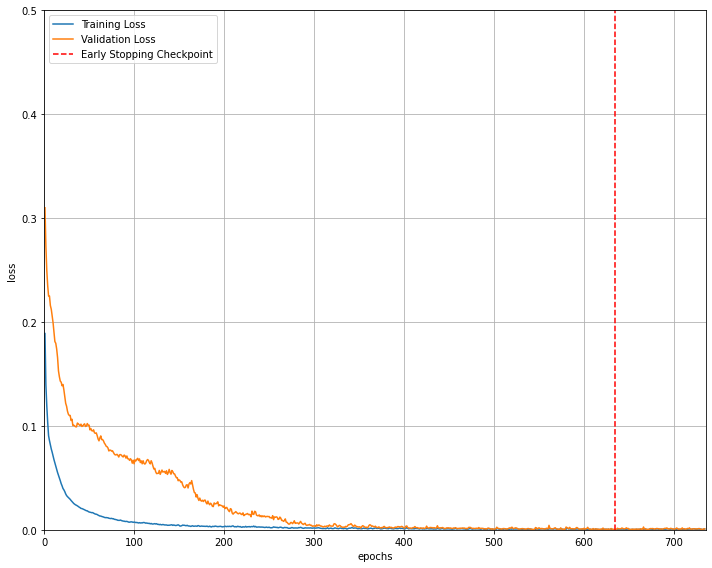

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:

# def train(model, train_loader, epoch):
def train(model, batch_size, patiences, epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patiences, verbose=True, delta=deltas)
    
    for epoch in range(1, epochs + 1):
        "train the model"
        
        model.train()
        for batch, x in tqdm(enumerate(train_loader, 1)):
            x = x.view(-1,len(x)).to(DEVICE)
            y = x.view(-1,len(x)).to(DEVICE)
            x = x.float()
            y = x.float()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            encoded, decoded = model(x)
            # calculate the loss
            loss = criterion(decoded, y)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        
        "validate the model"
        model.eval()
        for batch, x in tqdm(enumerate(valid_loder, 1)):
            x = x.view(-1,len(x)).to(DEVICE)
            y = x.view(-1,len(x)).to(DEVICE)
            x = x.float()
            y = x.float()

            encoded, decoded = model(x)
            loss = criterion(decoded, y)
            valid_losses.append(loss.item())
            
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        print(print_msg)
        
        #clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
                
    model.load_state_dict(torch.load('checkpoint.pt'))

    return(model, avg_train_losses, avg_valid_losses)

model, train_loss, valid_loss = train(model, batch_size, patiences, epochs)        


" Visualizing the Loss and the Early Stopping Checkpoint "
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

"Model Save"
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/Autoencoder_1bit/model_save.pth" 
torch.save(model.state_dict(), path)

5. 모델 SAVE(at gdrive)

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/Autoencoder_1bit/model_save.pth" 
torch.save(model.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


6. 모델 Load

In [7]:
"""optimal struct"""
"""1번부터 시작했다면, 3,4,5열은 주석처리해서 진행 """
model = Model().to(device)        
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

path = F"/content/gdrive/My Drive/Autoencoder_1bit/model_save.pth" 
model.load_state_dict(torch.load(path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<All keys matched successfully>

7. Test

In [10]:


"Test "
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

list_test = []
list_encoded = []
list_decoded = []

for x in tqdm(test_loader):
    # if len(target.data) != batch_size:
    #     break
    x = x.view(-1,len(x)).to(DEVICE)
    y = x.view(-1,len(x)).to(DEVICE)
    x = x.float()
    y = x.float()
    
    encoded_data_test, decoded_data_test = model(x)
    encoded_data_test = encoded_data_test.to(DEVICE)
    decoded_data_test = decoded_data_test.to(DEVICE)
    
    list_test.append(x)
    list_encoded.append(encoded_data_test)
    list_decoded.append(decoded_data_test)
    
    loss = criterion(decoded_data_test, y)
    
    test_loss  = loss.item()*x.size(0)
    _, pred = torch.max(decoded_data_test, 1)

print('Test Loss: {:.6f}\n'.format(test_loss))



100%|██████████| 1024/1024 [00:01<00:00, 642.06it/s]

Test Loss: 0.000018



In [ ]:
print(list_test[0].cpu().numpy())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


9. 데이터 후처리 및 평가

In [11]:
"Postprocessing: tensor -> numpy"
list_test_np = []
list_encoded_np = []
list_decoded_np = []
for i in range(len(list_test)):
    tmp_test1 = list_test[i].cpu().numpy()
    list_test_np.append(tmp_test1)
    tmp_test2 = list_encoded[i].cpu().detach().numpy()
    list_encoded_np.append(tmp_test2)
    tmp_test3 = list_decoded[i].cpu().detach().numpy()
    list_decoded_np.append(tmp_test3)

"Classification"
list_decoded_convert_np = []
tmp_list_decoded_np = list_decoded_np
min_temp = 0.5
for i in range(len(tmp_list_decoded_np)): 
    temp_data = tmp_list_decoded_np[i]
    
    for ii in range(len(tmp_test3.transpose())):
        if temp_data[0][ii] >= min_temp:
            temp_data[0][ii] = 1
        else:
            temp_data[0][ii] = 0
            
    list_decoded_convert_np.append(temp_data)

"Evaluation"
original = pd.DataFrame(list_test_np[0])
reconstruction = pd.DataFrame(list_decoded_convert_np[0])

for i in range(1,len(list_test_np)):
    tmp_original = pd.DataFrame(list_test_np[i])
    tmp_recon = pd.DataFrame(list_decoded_convert_np[i])
    original = pd.concat([original, tmp_original])
    reconstruction = pd.concat([reconstruction, tmp_recon])

eval_compare = original.values == reconstruction.values
#print(eval_compare)

eval_compare = pd.DataFrame(eval_compare)
eval_compare.to_csv("/content/gdrive/My Drive/Autoencoder_1bit/eval_compare.csv")

eval_compare.apply(pd.value_counts)

,0,1,2,3,4,5,6,7,8,9
False,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
True,1023,1024.0,1024.0,1024.0,1024.0,1023,1024.0,1024.0,1024.0,1024.0
